In [53]:
install.packages('rhdf5')

Warning message:
"package 'rhdf5' is not available (for R version 4.0.2)"


In [17]:
BiocManager::install(c('BiocParallel'))

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'BiocParallel'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'biocViews', 'cicero', 'enrichplot', 'forestplot',
  'GenomicFeatures', 'Gmisc', 'GOSemSim', 'Hmisc', 'metap', 'nlme', 'pbdZMQ',
  'Seurat'



In [11]:
library(monocle)

Warning message:
“package ‘monocle’ was built under R version 4.0.3”
Loading required package: VGAM

Warning message:
“package ‘VGAM’ was built under R version 4.0.3”
Loading required package: splines

Loading required package: DDRTree

Loading required package: irlba



# library

In [1]:
library(MAESTRO)
library(chromVAR)
library(Seurat)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg19)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BiocParallel)
library(motifmatchr)
library(SummarizedExperiment)
library(rhdf5)
library(dplyr)
library(motifmatchr)
library(chromVARmotifs)
# library(JASPAR2016)

library(ggplot2)
# library(spam)
# library(VennDiagram)
library(stringr)
# library(ggrepel)
# library(ggsignif)
library(qs)
register(MulticoreParam(8))


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



Attaching SeuratObject

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position

In [36]:
write10xCounts <- function(path, x, barcodes=colnames(x), gene.id=rownames(x), gene.symbol=gene.id, gene.type="Gene Expression",
    overwrite=FALSE, type=c("auto", "sparse", "HDF5"), genome="unknown", version=c("2", "3"),
    chemistry="Single Cell 3' v3", original.gem.groups=1L, library.ids="custom")
{
    # Doing all the work on a temporary location next to 'path', as we have permissions there.
    # This avoids problems with 'path' already existing.
    temp.path <- tempfile(tmpdir=dirname(path)) 
    on.exit({ 
        if (file.exists(temp.path)) { unlink(temp.path, recursive=TRUE) } 
    })

    # Checking the values.
    if (length(gene.id)!=length(gene.symbol) || length(gene.id)!=nrow(x)) {
        stop("lengths of 'gene.id' and 'gene.symbol' must be equal to 'nrow(x)'")
    }
    if (ncol(x)!=length(barcodes)) { 
        stop("'barcodes' must of of the same length as 'ncol(x)'")
    }

    # Determining what format to save in.
    version <- match.arg(version)
    type <- .type_chooser(path, match.arg(type))
    if (type=="sparse") {
        .write_sparse(temp.path, x, barcodes, gene.id, gene.symbol, gene.type, version=version)
    } else {
        .write_hdf5(temp.path, genome, x, barcodes, gene.id, gene.symbol, gene.type, version=version)
    }

    # We don't put this at the top as the write functions might fail; 
    # in which case, we would have deleted the existing 'path' for nothing.
    if (overwrite) {
        unlink(path, recursive=TRUE)
    } else if (file.exists(path)) { 
        stop("specified 'path' already exists")
    }
    file.rename(temp.path, path)
    return(invisible(TRUE))
}

#' @importFrom utils write.table
#' @importFrom Matrix writeMM
#' @importFrom R.utils gzip
.write_sparse <- function(path, x, barcodes, gene.id, gene.symbol, gene.type, version="2") {
    dir.create(path, showWarnings=FALSE)
    gene.info <- data.frame(gene.id, gene.symbol, stringsAsFactors=FALSE)

    if (version=="3") {
        gene.info$gene.type <- rep(gene.type, length.out=nrow(gene.info))
        mhandle <- file.path(path, "matrix.mtx")
        bhandle <- gzfile(file.path(path, "barcodes.tsv.gz"), open="wb")
        fhandle <- gzfile(file.path(path, "features.tsv.gz"), open="wb")
        on.exit({
            close(bhandle)
            close(fhandle)
        })
    } else {
        mhandle <- file.path(path, "matrix.mtx")
        bhandle <- file.path(path, "barcodes.tsv")
        fhandle <- file.path(path, "genes.tsv")
    }

    writeMM(x, file=mhandle)
    write(barcodes, file=bhandle)
    write.table(gene.info, file=fhandle, row.names=FALSE, col.names=FALSE, quote=FALSE, sep="\t")

    if (version=="3") {
        # Annoyingly, writeMM doesn't take connection objects.
        gzip(mhandle)
    }

    return(NULL)
}

#' @importFrom rhdf5 h5createFile h5createGroup h5write h5writeAttribute H5Gopen H5Fopen H5Gclose H5Fclose
#' @importFrom methods as
#' @importClassesFrom Matrix dgCMatrix
.write_hdf5 <- function(path, genome, x, barcodes, gene.id, gene.symbol, gene.type, version="3",
    chemistry="Single Cell 3' v3", original.gem.groups=1L, library.ids="custom")
{
    path <- path.expand(path) # protect against tilde's.
    h5createFile(path)

    if (version=="3") {
        group <- "matrix"
    } else {
        group <- genome
    }
    h5createGroup(path, group)

    h5write(barcodes, file=path, name=paste0(group, "/barcodes"))

    # Saving feature information.
    if (version=="3") {
        h5createGroup(path, file.path(group, "features"))

        h5write(gene.id, file=path, name=paste0(group, "/features/id"))
        h5write(gene.symbol, file=path, name=paste0(group, "/features/name"))
        h5write(rep(gene.type, length.out=length(gene.id)),
            file=path, name=paste0(group, "/features/feature_type"))

        h5write("genome", file=path, name=paste0(group, "/features/_all_tag_keys"))
        h5write(rep(genome, length.out=length(gene.id)),
            file=path, name=paste0(group, "/features/genome"))

        # Writing attributes.
        h5f <- H5Fopen(path)
        h5g <- H5Gopen(h5f, "/")
        h5writeAttribute(chemistry, h5obj=h5g, name="chemistry_description")
        h5writeAttribute("matrix", h5obj=h5g, name="filetype")
        h5writeAttribute(library.ids, h5obj=h5g, name="library_ids")
        h5writeAttribute(original.gem.groups, h5obj=h5g, name="original_gem_groups")
        h5writeAttribute(as.integer(version) - 1L, h5obj=h5g, name="version") # this is probably correct.
        H5Gclose(h5g)
        H5Fclose(h5f)

    } else {
        h5write(gene.id, file=path, name=paste0(group, "/genes"))
        h5write(gene.symbol, file=path, name=paste0(group, "/gene_names"))
    }

    # Saving matrix information.
    x <- as(x, "dgCMatrix")
    h5write(x@x, file=path, name=paste0(group, "/data"))
    h5write(dim(x), file=path, name=paste0(group, "/shape"))
    h5write(x@i, file=path, name=paste0(group, "/indices")) # already zero-indexed.
    h5write(x@p, file=path, name=paste0(group, "/indptr"))

    return(NULL)
}

.type_chooser <- function(path, type) {
    if (type=="auto") {
        type <- if (grepl("\\.h5", path)) "HDF5" else "sparse"
    }
    type
}

In [2]:
## this block is the function that used to perform chromVAR data analysis


# as_matrix <- function(mat){
#   tmp <- matrix(data=0L, nrow = mat@Dim[1], ncol = mat@Dim[2])
#   row_pos <- mat@i+1
#   col_pos <- findInterval(seq(mat@x)-1,mat@p[-1])+1
#   val <- mat@x
#   for (i in seq_along(val)){
#       tmp[row_pos[i],col_pos[i]] <- val[i]
#   }
#   row.names(tmp) <- mat@Dimnames[[1]]
#   colnames(tmp) <- mat@Dimnames[[2]]
#   return(tmp)
# }


RunchromVAR <- function(inputMat, min.c = 50, min.p = 500, organism = "GRCh38")
{
  message("Reading File!")
#   spam_input_matrix <- as.spam.dgCMatrix(inputMat)
  peaks <- data.frame(chr=unlist(strsplit(rownames(inputMat),'_'))[seq(1,nrow(inputMat)*3,3)], 
                 start=unlist(strsplit(rownames(inputMat),'_'))[seq(2,nrow(inputMat)*3,3)],
                 end=unlist(strsplit(rownames(inputMat),'_'))[seq(3,nrow(inputMat)*3,3)])  
  rownames(peaks) <- paste0(peaks[,1],'_',peaks[,2],'_',peaks[,3])
  peaks <- na.omit(peaks)
  message("Generating col.data!")
#   col.Data <- DataFrame(celltype=colnames(inputMat), depth=apply.spam(spam_input_matrix,2,sum))
  col.Data <- DataFrame(celltype=colnames(inputMat), depth=Matrix::colSums(inputMat))
  col.Data <- col.Data[which(col.Data[,2]>min.p),]
  message("Generating row.data!")
#   row.Data <- DataFrame(peaks=rownames(inputMat), depth=apply.spam(spam_input_matrix[,col.Data[,1]],1,sum))
  row.Data <- DataFrame(peaks=rownames(inputMat), depth=Matrix::rowSums(inputMat[,col.Data[,1]]))
  row.Data <- row.Data[which(row.Data[,2]>min.c),]
#   finalPeak <- as.matrix(peaks[row.Data[,1],])
#   finalCount <- as.matrix(inputMat[row.Data[,1],col.Data[,1]])
  finalPeak <- peaks[row.Data[,1],]
  finalCount <- inputMat[row.Data[,1],col.Data[,1]]
  rowRanges <- GRanges(as.character(finalPeak[,1]),IRanges(as.integer(finalPeak[,2]),as.integer(finalPeak[,3])),
                       strand="*",score=as.integer(5),qval=1,name=rownames(finalPeak))
  resizedRowRanges <- resize(rowRanges, width=500, fix="center")
  chromVAR_counts  = SummarizedExperiment(assays=SimpleList(counts=finalCount),rowRanges=resizedRowRanges, colData=col.Data)
  

  message("chromVAR analysis ...")
  if(organism == "GRCh38") {
     chromVAR_counts = addGCBias(chromVAR_counts, genome = BSgenome.Hsapiens.UCSC.hg38)
#      motifs <- getJasparMotifs(species = "Homo sapiens")
#      motif_ix = matchMotifs(motifs, chromVAR_counts, genome = BSgenome.Hsapiens.UCSC.hg38)
     data(human_pwms_v2)
     motif_ix = matchMotifs(human_pwms_v2, chromVAR_counts, genome = BSgenome.Hsapiens.UCSC.hg38)}
  if(organism == "GRCm38") {
     chromVAR_counts = addGCBias(chromVAR_counts, genome = BSgenome.Mmusculus.UCSC.mm10)
#      motifs <- getJasparMotifs(species="Mus musculus")
#      motif_ix = matchMotifs(motifs, chromVAR_counts, genome = BSgenome.Mmusculus.UCSC.mm10)
     data(mouse_pwms_v2)
     motif_ix = matchMotifs(mouse_pwms_v2, chromVAR_counts, genome = BSgenome.Mmusculus.UCSC.mm10)}  
  dev = computeDeviations(object = chromVAR_counts, annotations = motif_ix)
  variability = computeVariability(dev)
  zscore = assays(dev)$z
  rownames(zscore) = variability[,1]
#   variability <- computeVariability(dev)
  
  message("Finished!")
  return(list(dev = dev, zscore = zscore, variability = variability))
}


mergeChromVarResult <- function(Seurat_object, chromVAR_z_frame){
    # zframe : each row is a cell, each column is a TF/Gene
#     chromVarResult = readRDS(SeuratObject)
    p1 <- DimPlot(object = Seurat_object$ATAC, pt.size = 0.5)
    show(p1)
    Seurat_object$zscore <- chromVAR_z_frame
    Seurat_object$ATAC@meta.data <- cbind(Seurat_object$ATAC@meta.data, chromVAR_z_frame[match(rownames(Seurat_object$ATAC@meta.data), rownames(chromVAR_z_frame)),])
#     SeuratObject$ATAC@meta.data <- merge(SeuratObject$ATAC@meta.data, chromVARzframe, by="row.names", all = TRUE)
#     rownames(Seurat_object$ATAC@meta.data) <- Seurat_object$ATAC@meta.data[,1]
    for (i in colnames(chromVAR_z_frame)) {
        Seurat_object$ATAC@meta.data[i][is.na(Seurat_object$ATAC@meta.data[i])] <- min(Seurat_object$ATAC@meta.data[i], na.rm=T)
    }
    return(Seurat_object)
}



# HSC

In [2]:
HSC.Large.peak <- Read10X_h5('/mnt/Storage2/home/dongxin/Projects/scATAC/HSC/data/bm/remove_alt_10x/remove_alt.h5')

In [10]:
HSC.Large.peak <- HSC.Large.peak[!grepl('-',rownames(HSC.Large.peak)),]

In [59]:
HSC.Large.peak <- HSC.Large.peak.new[!grepl('random',rownames(HSC.Large.peak)),]

In [63]:
HSC.Large.peak <- HSC.Large.peak.new[!grepl('chrUn',rownames(HSC.Large.peak)),]

In [ ]:
HSC.Large.peak <- HSC.Large.peak[which(Matrix::rowSums(HSC.Large.peak)>50),]

In [88]:
writeMM(HSC.Large.peak, 'HSC/data/bm/matrix_10X_format/matrix.mtx')
write.table(rownames(HSC.Large.peak), 'HSC/data/bm/matrix_10X_format/all/features.tsv', row.names = F, col.names = F, quote = F)
write.table(colnames(HSC.Large.peak), 'HSC/data/bm/matrix_10X_format/all/barcodes.tsv', row.names = F, col.names = F, quote = F)

In [4]:
HSC.result <- ATACRunSeurat(inputMat = HSC.Large.peak , 
                                project = "HSC/ATAC/HSC_scATAC", 
                                method = "LSI",
                                min.c = 50,
                                min.p = 500,
                                dims.use = 1:30,
                                cluster.res = 0.6,
                                peaks.test.use = "presto",
                                peaks.cutoff = 1e-05)
HSC.result.RP <- ATACCalculateGenescore(inputMat = HSC.Large.peak)
HSC.result$ATAC <- ATACAttachGenescore(HSC.result$ATAC, HSC.result.RP)
HSC.result$ATAC <- ATACAnnotateCelltype(HSC.result$ATAC, signatures = "human.immune.CIBERSORT", min.score = 0, genes.test.use = "presto", genes.cutoff = 1E-5, orig.ident = NULL)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
LSI analysis ...

Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

UMAP analysis ...

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 115792
Number of edges: 3508126

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9414
Number of communities: 23
Elapsed time: 95 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Identify cluster specific peaks ...

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Identify cluster specific genes based on RP score ...

The following `from` values were not present in `x`: ActMemCD4Tcells, CD8Tex, Eosinophils, Fibroblasts, MacrophagesM0, MacrophagesM1, MacrophagesM2, Myofibroblasts, NaiveCD4Tcells, RestDCs, RestMast, RestNK, RestpDCs, TMKI67



In [10]:
HSC.Large.peak

   [[ suppressing 31 column names ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00404_N03’, ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00461_N02’, ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00600_N02’ ... ]]

   [[ suppressing 31 column names ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00404_N03’, ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00461_N02’, ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00600_N02’ ... ]]

   [[ suppressing 31 column names ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00404_N03’, ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00461_N02’, ‘Exp100-Sample9.all_Tn5-AAAGAA_BC00600_N02’ ... ]]



155580 x 136463 sparse Matrix of class "dgCMatrix"
                                                                                           
chr1_11036_11536       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_12478_12978       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_13307_13807       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_14399_14899       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_15399_15899       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_15985_16485       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_17235_17735       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_18499_18999       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_21034_21534       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
chr1_24465_24965       . . . 

In [5]:
qsave(HSC.result, "HSC/ATAC/HSC.qs", nthreads = 2)
hsc_singlecell = as.SingleCellExperiment(HSC.result$ATAC)
saveRDS(hsc_singlecell, 'HSC/ATAC/HSC_single_cell_experiment.rds')

In [11]:
HSC_chromVAR <- RunchromVAR(HSC.Large.peak)

Reading File!

Generating col.data!

Generating row.data!

chromVAR analysis ...

Finished!



In [12]:
qsave(HSC_chromVAR, "HSC/ATAC/HSC_chromVAR.qs")

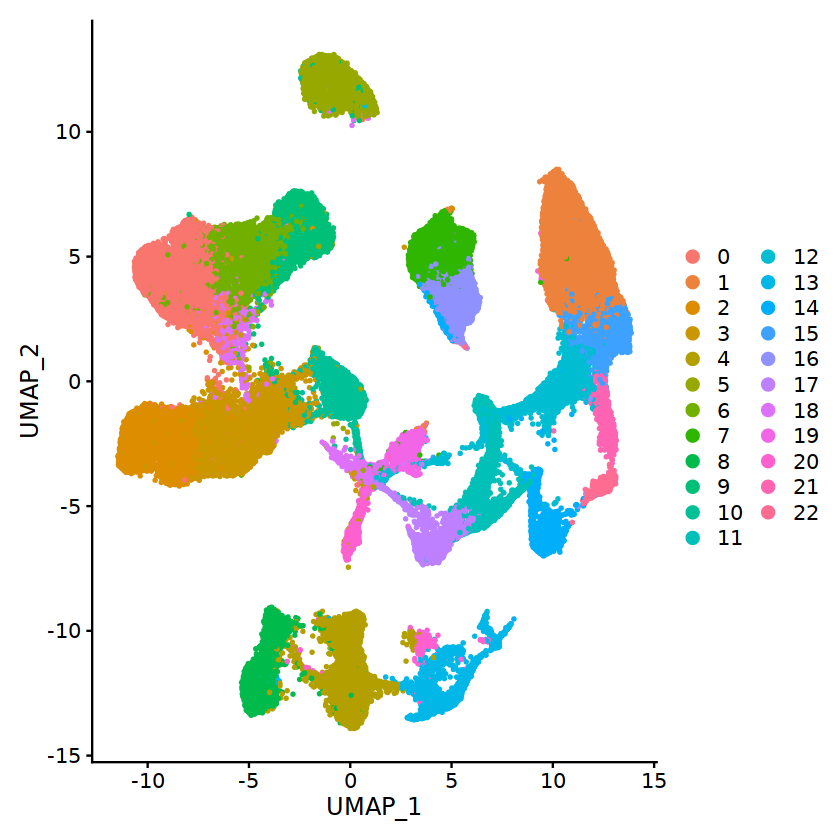

In [13]:
HSC.result.with.chromVAR <- mergeChromVarResult(HSC.result, t(HSC_chromVAR$zscore))

In [14]:
qsave(HSC.result.with.chromVAR, "HSC/ATAC/HSC_Seurat_object_chromVAR.qs")

In [16]:
HSC.result.with.chromVAR <- qread("HSC/ATAC/HSC_Seurat_object_chromVAR.qs")

In [17]:
TFlist = c('RFX3','BCL11A','BCL11B', 'ID4', 'EBF1', 'BRD4')

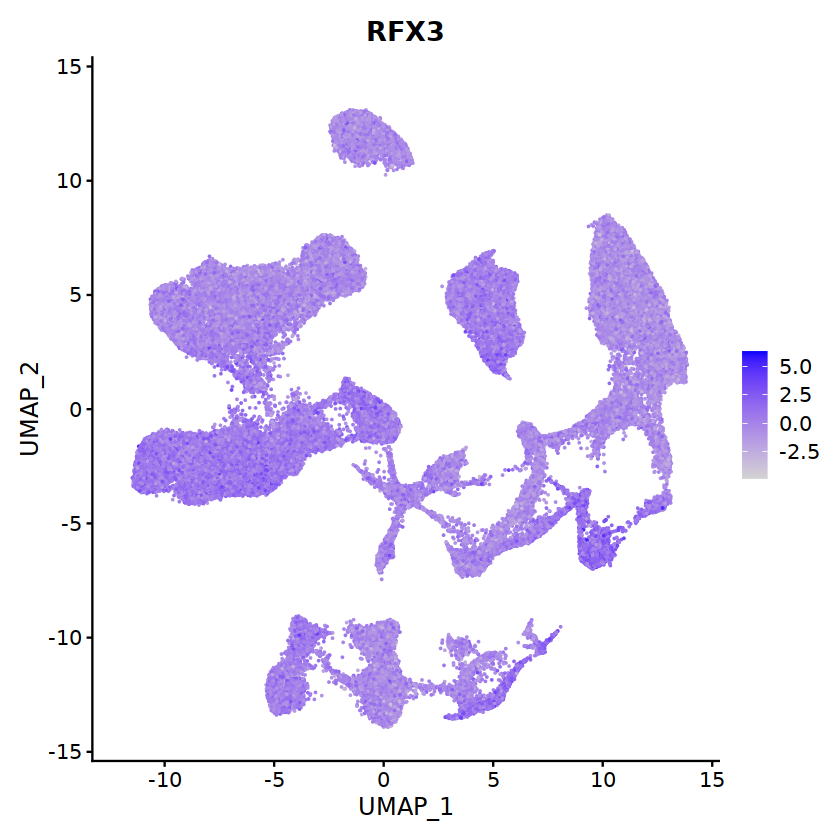

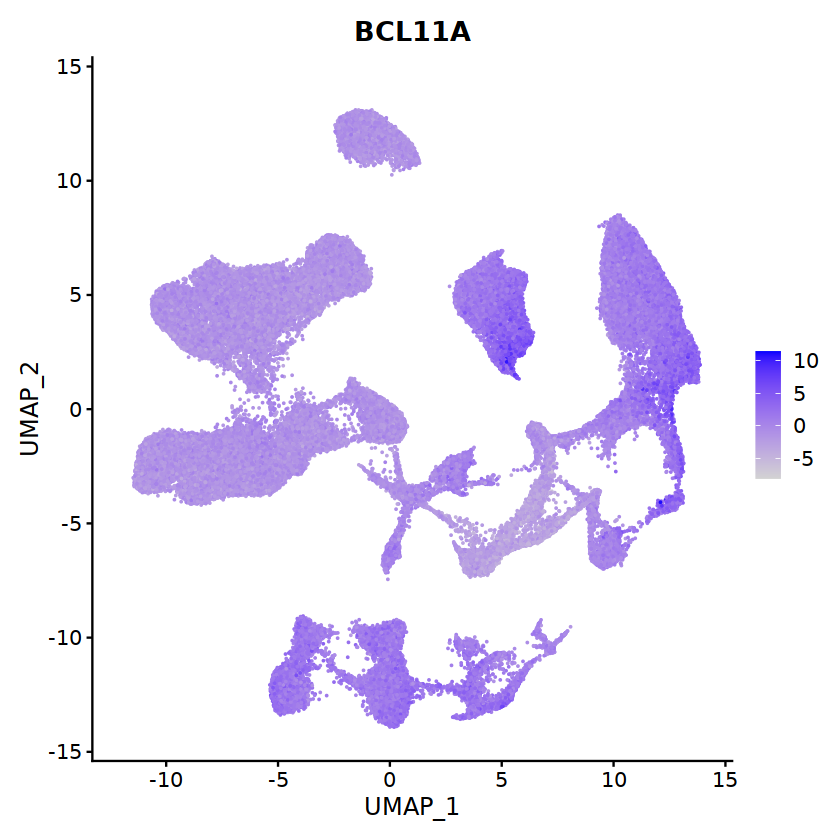

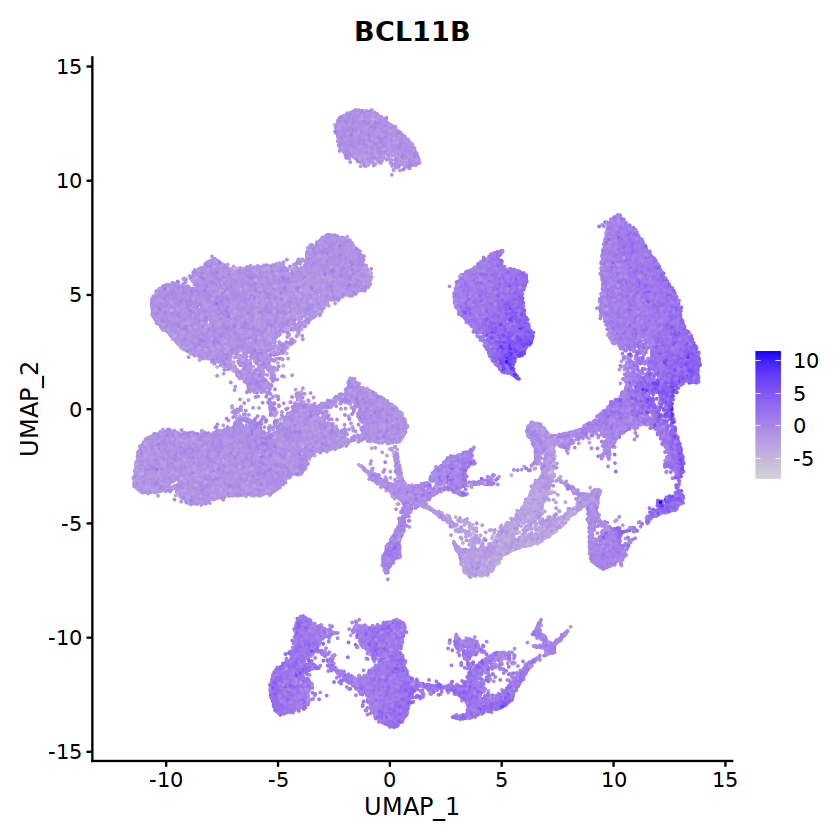

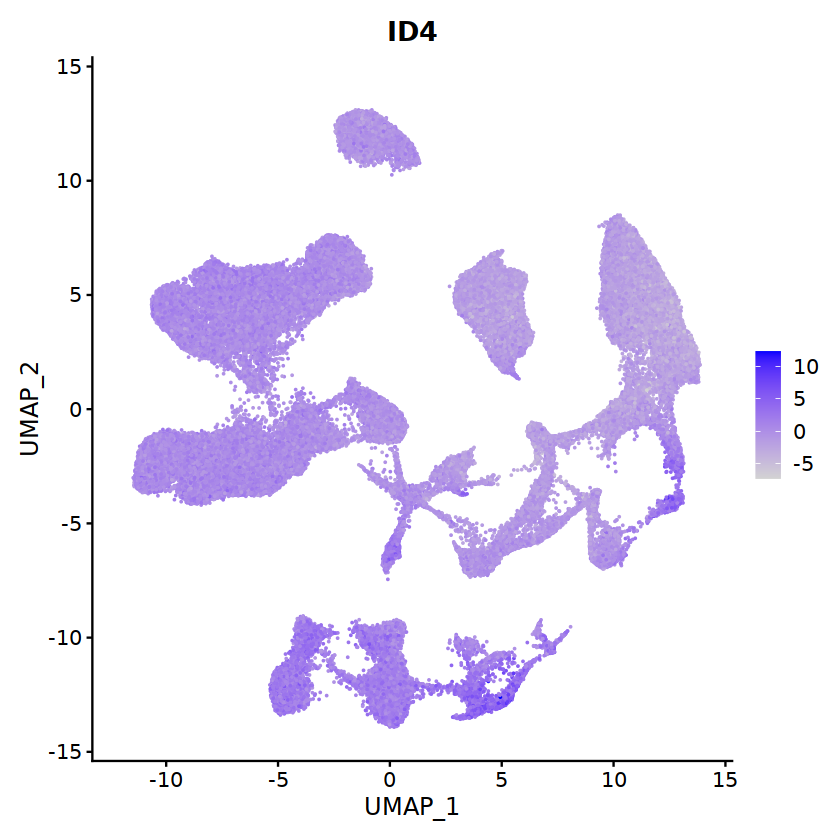

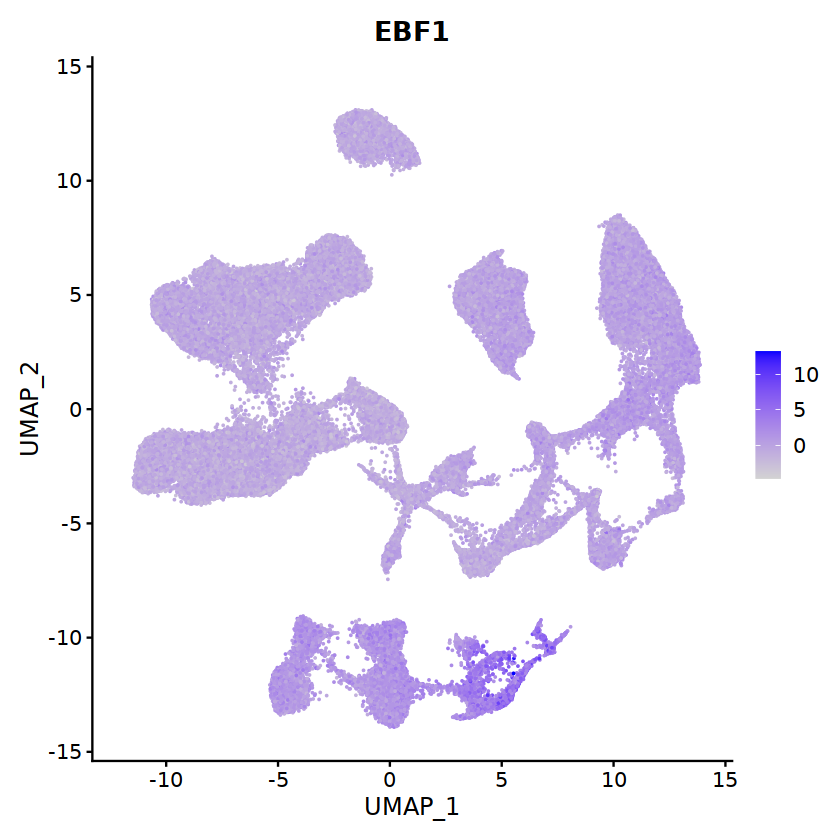

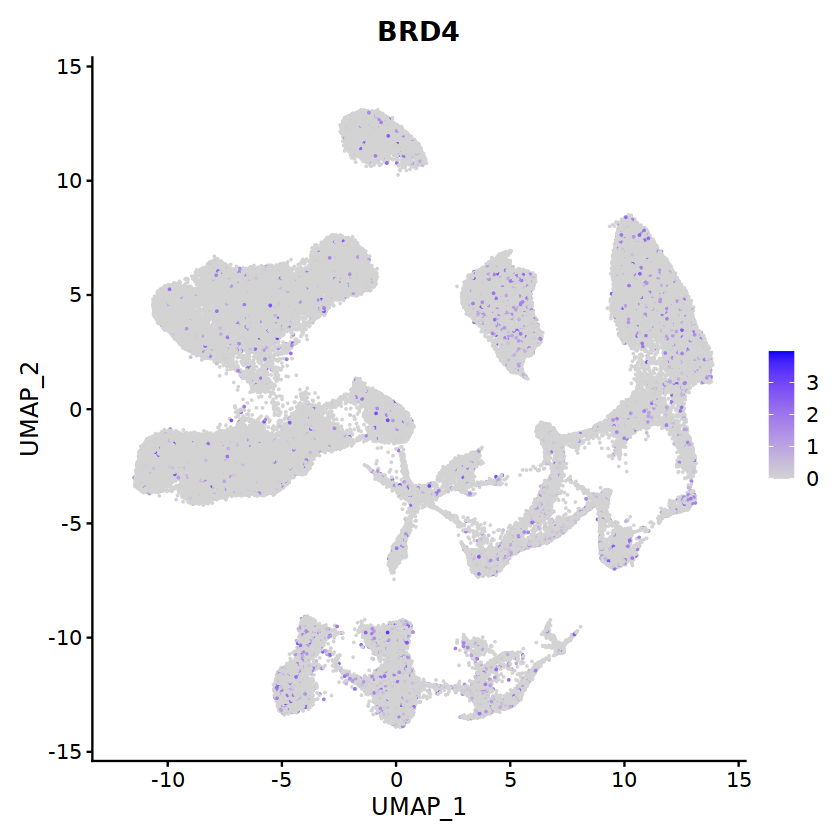

In [18]:
for (i in TFlist) {
    fig <- FeaturePlot(object = HSC.result.with.chromVAR$ATAC, feature=i)
    show(fig)
}

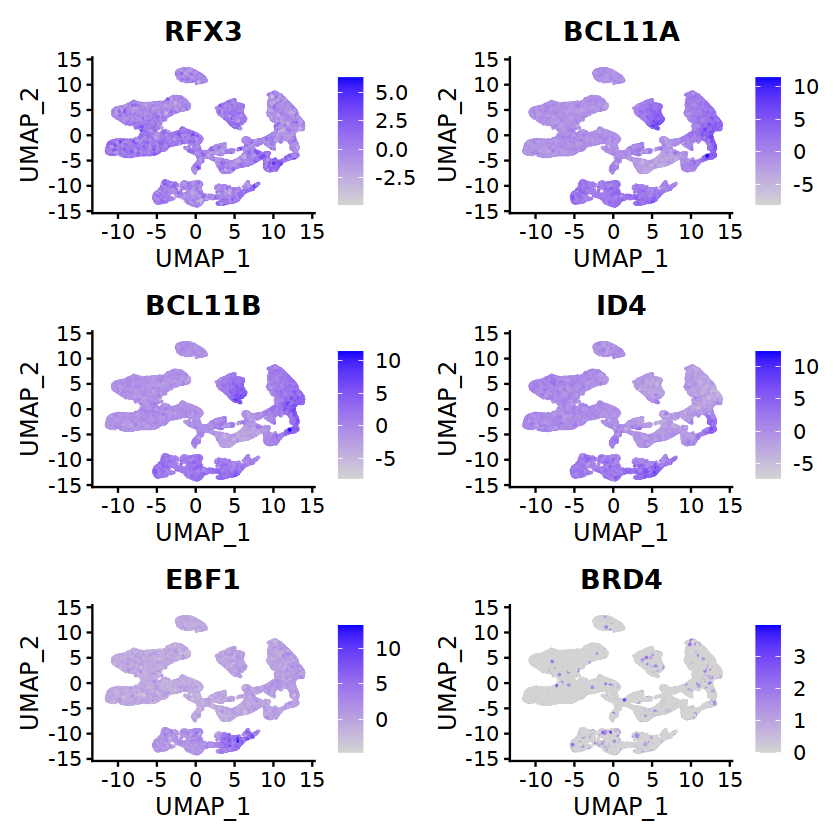

In [19]:
fig <- FeaturePlot(object = HSC.result.with.chromVAR$ATAC, feature=TFlist)
show(fig)

# BCC

## ATAC-seq

In [25]:
bcc.peak <- Read10X_h5('BCC/data/GSE129785_BCC_scATAC_peak_count.h5')
# bcc.peak <- bcc.peak[which(Matrix::rowSums(bcc.peak)>50),]

In [8]:
bcc.gene <- ATACCalculateGenescore(bcc.peak)

In [9]:
bcc.ATAC.res <- ATACRunSeurat(inputMat = bcc.peak , 
                                project = "BCC/ATAC/bcc_scATAC", 
                                method = "LSI",
                                min.c = 50,
                                min.p = 500,
                                dims.use = 1:30,
                                cluster.res = 0.6,
                                peaks.test.use = "presto",
                                peaks.cutoff = 1e-05)

bcc.ATAC.res$ATAC <- ATACAttachGenescore(bcc.ATAC.res$ATAC, bcc.gene)
bcc.ATAC.res$ATAC <- ATACAnnotateCelltype(bcc.ATAC.res$ATAC, 
                                          signatures = "human.immune.CIBERSORT", 
                                          min.score = 0.1, 
                                          genes.test.use = "presto", 
                                          genes.cutoff = 1E-5)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
LSI analysis ...

Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

UMAP analysis ...

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37818
Number of edges: 1151375

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9144
Number of communities: 22
Elapsed time: 10 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Identify cluster specific peaks ...

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Identify cluster specific genes based on RP score ...

The following `from` values were not present in `x`: ActDCs, ActMast, ActpDCs, Eosinophils, MacrophagesM0, MacrophagesM1, MacrophagesM2, Myofibroblasts, NaiveBcells, NaiveCD4Tcells, RestDCs, RestMast, RestNK, RestpDCs, TMKI67



In [11]:
bcc.ATAC.res$ATAC

An object of class Seurat 
573164 features across 37818 samples within 2 assays 
Active assay: ACTIVITY (42393 features, 2000 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap

In [12]:
qsave(bcc.ATAC.res, "BCC/ATAC/BCC_ATAC_GSE129785.qs", nthreads = 2)

In [ ]:
bcc.ATAC.res <- qread("BCC/ATAC/BCC_ATAC_GSE129785.qs")

In [ ]:
bcc.singlecell.experiment <- as.SingleCellExperiment(bcc.ATAC.res$ATAC)
saveRDS(bcc.singlecell.experiment, "BCC/ATAC/BCC_ATAC_single_cell_experiment.rds")

An object of class "SimpleAssays"
Slot "data":
List of length 2
names(2): counts logcounts


## RNA-seq

In [ ]:
# bcc <- read.table('BCC_GSE129785/GSE123813/GSE123813_bcc_scRNA_counts.txt', sep = "\t")

In [15]:
bcc <- qread("BCC/data/GSE123813_bcc_scRNA_counts.qs")

In [16]:
bcc.expr <- RNACountToTPM(bcc, idType = "Symbol")

Warning message in RNACountToTPM(bcc, idType = "Symbol"):
“Omit 4886 genes of which length is not available !”


In [ ]:
expre_table

In [17]:
qsave(bcc.expr, "BCC/RNA/BCC_RNA_GSE123813_expr.qs")

# bcc <- Read10X_h5('BCC_GSE129785/GSE123813_BCC_scRNA_counts.h5')
# bcc.expr <- RNACountToTPM(bcc, idType = "Symbol")
bcc.expr <- log2(bcc.expr/10+1)
bcc.RNA.res <- RNARunSeurat(inputMat = bcc.expr, 
                              project = "BCC/RNA/GSE123813_BCC_scRNA", 
                              min.c = 10,
                              min.g = 500,
                              dims.use = 1:15,
                              variable.genes = 2000, 
                              organism = "GRCh38",
                              cluster.res = 0.6,
                              genes.test.use = "presto",
                              genes.cutoff = 1e-05)
data(human.immune.CIBERSORT)
bcc.RNA.res$RNA <- RNAAnnotateCelltype(RNA = bcc.RNA.res$RNA, 
                                         gene = bcc.RNA.res$gene,
                                         signatures = human.immune.CIBERSORT, 
                                         min.score = 0.05)

Normalization and identify variable genes ...

Regressing out nCount_RNA

Centering and scaling data matrix

PCA analysis ...

PC_ 1 
Positive:  TRBC2, CXCR4, CD52, CD7, TRBC1, HCST, LTB, TNFRSF18, CCL5, TNFRSF4 
	   NKG7, DUSP2, GZMB, GNLY, IFITM1, GZMH, HIST1H4C, AC133644.2, SIT1, AC017002.1 
	   ZBED2, AC090498.1, CLIC3, CCL4, XCL2, IFNG, TRGV10, XCL1, TRBV20-1, CCR8 
Negative:  S100A14, KRT17, KRT14, SFN, S100A2, KRT15, KRT5, LGALS7B, GJB2, KRT16 
	   TM4SF1, EFNA1, GJB6, CYR61, EDN1, SOX9, FXYD3, TACSTD2, KRT6B, BGN 
	   APOE, KRT6A, IER3, ELF3, MAFB, SLPI, EGR1, IRX2, CLDN4, GJB3 
PC_ 2 
Positive:  KRT16, LGALS7B, S100A14, SFN, KRT15, FXYD3, KRT6A, KRT6B, CLDN4, KRT14 
	   ELF3, LY6D, GJB3, SLPI, KRT17, KRT5, S100A7, TACSTD2, S100A2, EDN1 
	   CALML5, GJB5, SOX9, RHOV, KRTDAP, GJB6, PRSS8, EFNA1, CALML3, KRT1 
Negative:  COL1A2, COL3A1, LUM, CTSK, MXRA8, SOD3, TNFAIP6, COL6A1, DCN, ISLR 
	   CTHRC1, THY1, SERPINF1, SFRP2, PCOLCE, COL1A1, CD248, CPXM1, CST3, C11orf96 
	   TMEM119,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 52917
Number of edges: 1659765

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9053
Number of communities: 17
Elapsed time: 28 seconds


Identify cluster specific genes ...



ERROR: Error in plyr::mapvalues(x = bcc.RNA.res$RNA@meta.data$seurat_clusters, : `from` and `to` vectors are not the same length.


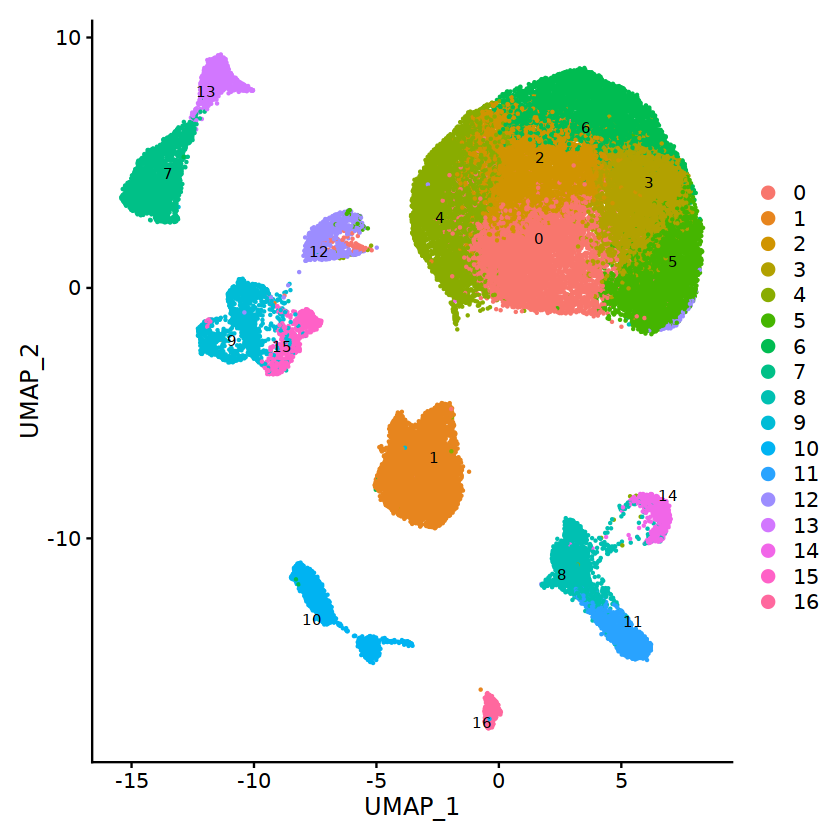

In [25]:
DimPlot(bcc.RNA.res$RNA, label = TRUE, pt.size = 0.2, label.size = 3, repel = T)

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)
DotPlot(bcc.RNA.res$RNA, features = c('BCL11A', 'ADAM8', 'CD8A','LAG3', 'FOXP3', 'KLRC1','CD68', 'CD4'))

In [ ]:
bcc.RNA.anno <- read.delim("BCC/data/GSE123813_bcc_all_metadata.txt")
bcc.RNA.res$RNA@meta.data <- cbind(bcc.RNA.res$RNA@meta.data, bcc.RNA.anno[match(colnames(bcc.RNA.res$RNA), bcc.RNA.anno[,1]),c(2,3,5)])
p = DimPlot(object <- bcc.RNA.res$RNA, label = TRUE, pt.size = 0.2, group.by = "cluster", label.size = 3, repel = TRUE)
ggsave(paste0(bcc.RNA.res$RNA@project.name, "_annotated_meta.png"), p, width=6.5, height=4.5)

In [52]:
current.cluster.ids <- levels(bcc.RNA.res$RNA@meta.data$seurat_clusters)
# new.cluster.ids <- c("0:CD8Teff", "1:Treg", "2:B", "3:Treg", "4:CD4Tconv", 
#                        "5:Treg", "6:MonoMac", "7:Malignant", "8:CD8Teff", "9:Plasma", 
#                        "10:CAF", "11:CD8Teff", "12:Malignant", "13:pDC", "14:Plasma", 
#                        "15:TProliferation", "16:Endothelial", "17:Melanocyte")
# new.cluster.ids <- c("0:CD8Teff", "1:CD4Tconv", "2:B", "3:CD4Tconv", "4:Treg", 
#                        "5:CD8Teff", "6:CD8Teff", "7:Malignant", "8:mDC", "9:Plasma", 
#                        "10:MonoMac", "11:CAF", "12:TProliferation", "13:pDC", "14:Malignant", 
#                        "15:Plasma", "16:Endothelial", "17:CAF", "18:Melanocyte")
new.cluster.ids <- c("CD8Teff", "B", "CD8Teff", "Treg", "NK", 
                       "Treg", "CD4Tconv", "Malignant", "mDC", "Plasma", 
                       "CAF", "MonoMac", "TProliferation", "Malignant", "pDC", 
                       "Plasma", "Endothelial")
assign.ident.mannual <- plyr::mapvalues(x = bcc.RNA.res$RNA@meta.data$seurat_clusters, from = current.cluster.ids, to = new.cluster.ids)
bcc.RNA.res$RNA@meta.data$assign.ident.CIBERSORT = bcc.RNA.res$RNA@meta.data$assign.ident
bcc.RNA.res$RNA@meta.data$assign.ident = assign.ident.mannual
p = DimPlot(object = bcc.RNA.res$RNA, label = TRUE, pt.size = 0.2, group.by = "assign.ident", label.size = 3, repel = T)
ggsave(paste0(bcc.RNA.res$RNA@project.name, "_annotated_mannually.png"), p, width=6, height=4)

In [53]:
qsave(bcc.RNA.res, 'BCC/RNA/bcc_RNA_seq_seurat.qs')

In [8]:
bcc.RNA.res <- qread('BCC/RNA/bcc_RNA_seq_seurat.qs')

In [52]:
bcc.coembedded.res <- Incorporate(RNA = bcc.RNA.res$RNA, ATAC = bcc.ATAC.res$ATAC, project = "BCC/integrated/BCC_integrated", dims.use = 1:15)

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
“Running CCA on different assays”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 55262 anchors

Filtering anchors

	Retained 9397 anchors

Extracting within-dataset neighbors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data

Centering data matrix

00:39:28 UMAP embedding parameters a = 0.9922 b = 1.112

00:39:28 Read 90735 rows and found 15 numeric columns

00:39:28 Using Annoy for neighbor search, n_neighbors = 30

00:39:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

00:39:56 Writing NN index

In [54]:
qsave(bcc.coembedded.res, 'BCC/integrated/embed.qs')

In [ ]:
bcc.expr = qread("BCC/RNA/BCC_RNA_GSE123813_expr.qs")

metadata = read.csv('BCC/integrated/BCC_integrated_metadata.tsv',sep = '\t')

In [14]:
CD8Teff_cells <- rownames(subset(metadata, assign.ident == "CD8Teff" & tech=="RNA"))
Treg_cells <- rownames(subset(metadata, assign.ident == "Treg" & tech=="RNA"))
B_cells <- rownames(subset(metadata, assign.ident == "B" & tech=="RNA"))
CD4Tconv_cells <- rownames(subset(metadata, assign.ident == "CD4Tconv" & tech=="RNA"))
MonoMac_cells <- rownames(subset(metadata, assign.ident ==   "MonoMac"  & tech=="RNA"))
Malignant_cells <- rownames(subset(metadata, assign.ident == "Malignant"  & tech=="RNA"))
Plasma_cells <- rownames(subset(metadata, assign.ident == "Plasma"  & tech=="RNA"))
CAF_cells <- rownames(subset(metadata, assign.ident == "CAF"  & tech=="RNA"))
pDC_cells <- rownames(subset(metadata, assign.ident == "pDC" & tech=="RNA"))
TProliferation_cells <- rownames(subset(metadata, assign.ident == "TProliferation"  & tech=="RNA"))
Endothelial_cells <- rownames(subset(metadata, assign.ident == "Endothelial"  & tech=="RNA"))
NK_cells <- rownames(subset(metadata, assign.ident == "NK"  & tech=="RNA"))
mDC_cells <- rownames(subset(metadata, assign.ident == "mDC"  & tech=="RNA"))

In [15]:
CD8Teff <- apply(bcc.expr[,CD8Teff_cells],1, mean)
Treg <- apply(bcc.expr[,Treg_cells],1, mean)
B <- apply(bcc.expr[,B_cells],1, mean)
CD4Tconv <- apply(bcc.expr[,CD4Tconv_cells],1, mean)
MonoMac <- apply(bcc.expr[,MonoMac_cells],1, mean)
Malignant <- apply(bcc.expr[,Malignant_cells],1, mean)
Plasma <- apply(bcc.expr[,Plasma_cells],1, mean)
CAF <- apply(bcc.expr[,CAF_cells],1, mean)
pDC <- apply(bcc.expr[,pDC_cells],1, mean)
TProliferation <- apply(bcc.expr[,TProliferation_cells],1, mean)
Endothelial <- apply(bcc.expr[,Endothelial_cells],1, mean)
NK <- apply(bcc.expr[,NK_cells],1, mean)
mDC <- apply(bcc.expr[,mDC_cells],1, mean)

expre_table = cbind(CD8Teff, Treg, B, CD4Tconv, MonoMac, Malignant, Plasma, CAF, pDC, TProliferation, Endothelial, NK,mDC)

write.table(expre_table,'BCC/RNA/expression.cluster.txt', sep = "\t", quote = FALSE)

### chromVar

In [27]:
chromVAR <- qread('BCC/BCC_GSE129785_chromVAR_result_more_motif.qs')

In [38]:
write.table(chromVAR$ATAC@meta.data[,12:881], 'BCC/chromVAR_z_table.txt', sep = '\t', quote = FALSE)

In [5]:
bcc.coembedded.res <- qread('BCC/integrated/embed.qs')

# PBMC

In [3]:
pbmc_inputMat <- Read10X_h5('example/PBMC/data/PBMC_granulocyte_sorted_10k_peak_count.h5')

## ATAC-seq analysis

In [5]:
pbmc_RNA_object <- readRDS('example/PBMC/data/PBMC_granulocyte_sorted_10k_scRNA_Object.rds')

In [15]:
rna_bc <- rownames(pbmc_RNA_object$RNA@meta.data)

key = read.table('example/PBMC/barcode_key.txt',sep='\t', header=TRUE)

key[which(key$RNA %in% rna_bc),'ATAC']

atac_bc <- key[which(key$RNA %in% rna_bc),'ATAC']

In [34]:
atac_match_bc <- colnames(pbmc_inputMat)[colnames(pbmc_inputMat) %in% atac_bc]

In [37]:
filter_pbmc_count <- pbmc_inputMat[,atac_match_bc]

In [ ]:
# gene.id = rownames(filter_pbmc_count)
# write10xCounts(
#   'example/PBMC/data/PBMC_granulocyte_sorted_10k_peak_count_filter_by_match.h5',
#   filter_pbmc_count,
#   barcodes = colnames(filter_pbmc_count),
#   gene.id = rownames(filter_pbmc_count),
#   gene.symbol = gene.id,
#   gene.type = "Chromatin Accessibility",
#   overwrite = FALSE,
#   type = "HDF5",
#   genome = "hg38",
#   version = "3",
#   chemistry = "Single Cell 3' v3",
#   original.gem.groups = 1L,
#   library.ids = "custom"
# )

In [40]:
pbmc.gene <- ATACCalculateGenescore(filter_pbmc_count, organism = "GRCh38")

In [41]:
pbmc.ATAC.res <- ATACRunSeurat(inputMat = filter_pbmc_count,
                                 project = "example/PBMC/analysis",
                                 min.c = 50,
                                 min.p = 500,
                                 method = "LSI",
                                 dims.use = 1:30,
                                 cluster.res = 0.6,
                                 only.pos = TRUE,
                                 peaks.test.use = "presto",
                                 peaks.cutoff = 1e-05,
                                 peaks.pct = 0.1,
                                 peaks.logfc = 0.2)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
LSI analysis ...

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

UMAP analysis ...

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
17:06:50 UMAP embedding parameters a = 0.9922 b = 1.112

17:06:51 Read 11010 rows and found 30 numeric columns

17:06:51 Using Annoy for neighbor search, n_neighbors = 30

17:06:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:06:56 Writing NN index file to temp file /tmp/RtmpyiawVk/file

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11010
Number of edges: 334447

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9110
Number of communities: 17
Elapsed time: 2 seconds


Identify cluster specific peaks ...



In [42]:
pbmc.ATAC.res$ATAC <- ATACAttachGenescore(ATAC = pbmc.ATAC.res$ATAC, RPmatrix = pbmc.gene)
data(human.immune.CIBERSORT)
pbmc.ATAC.res$ATAC <- ATACAnnotateCelltype(ATAC = pbmc.ATAC.res$ATAC,
                                             signatures = human.immune.CIBERSORT,
                                             min.score = 0.1,
                                             genes.test.use = "presto",
                                             genes.cutoff = 1E-5)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Centering and scaling data matrix

Identify cluster specific genes based on RP score ...



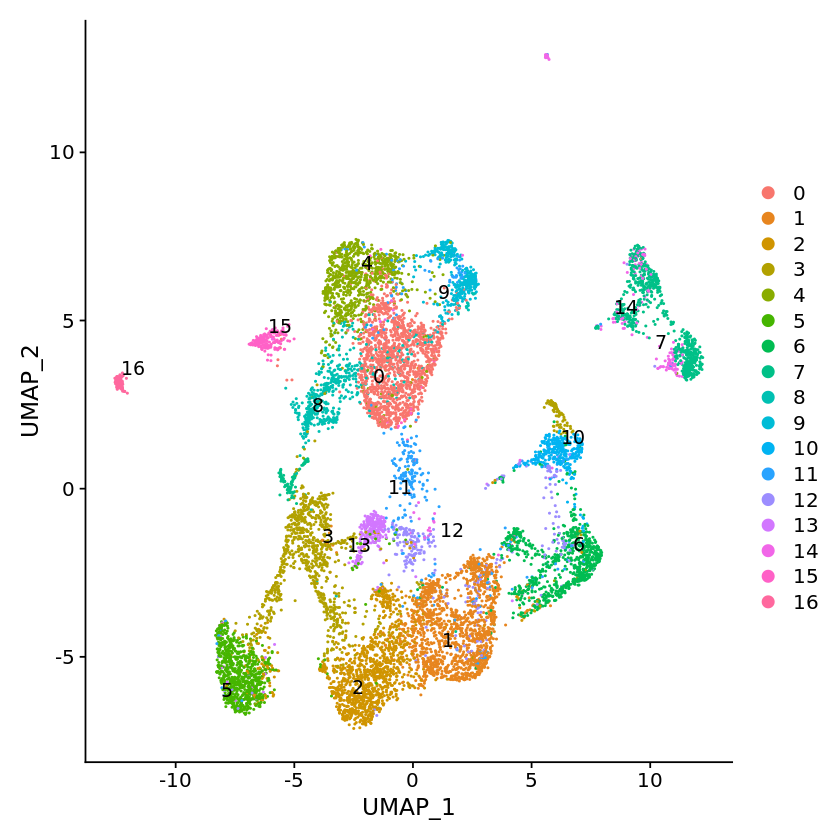

In [47]:
DimPlot(pbmc.ATAC.res$ATAC, label = TRUE, pt.size = 0.2, repel = T)

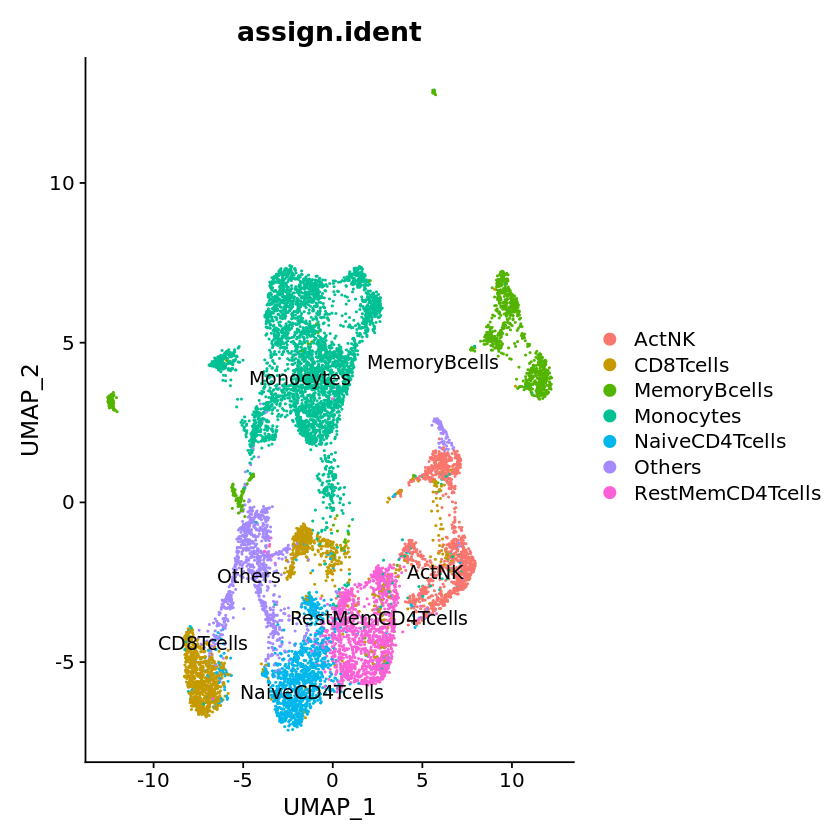

In [48]:
DimPlot(pbmc.ATAC.res$ATAC, label = TRUE, pt.size = 0.2, repel = T, group.by='assign.ident')

In [49]:
pbmc.ATAC.singlecellexperiment <- as.SingleCellExperiment(pbmc.ATAC.res$ATAC)

In [50]:
saveRDS(pbmc.ATAC.singlecellexperiment,'example/PBMC/pbmc_ATAC_singlecellexperiment.rds')

### chromVAR running

In [ ]:
pbmc10x_chromVAR <- RunchromVAR(pbmc_10X_inputMat)

In [ ]:
# pbmc10x_chromVAR would have 3 keys: dev,variability,zscore
plotVariability(pbmc10x_chromVAR$variability, use_plotly = T) 

In [ ]:
qsave(pbmc10x_chromVAR, "10X_ATAC/per_50_cell_peak/1k_TF_index/run_chromVAR_result.qs")

In [50]:
pbmc10x_chromVAR <- qread("10X_ATAC/per_50_cell_peak/1k_TF_index/run_chromVAR_result.qs")

In [51]:
TFlist <- head(pbmc10x_chromVAR$variability[order(pbmc10x_chromVAR$variability['variability'], decreasing=T),],5)$name
z_frame <- t(pbmc10x_chromVAR$zscore)

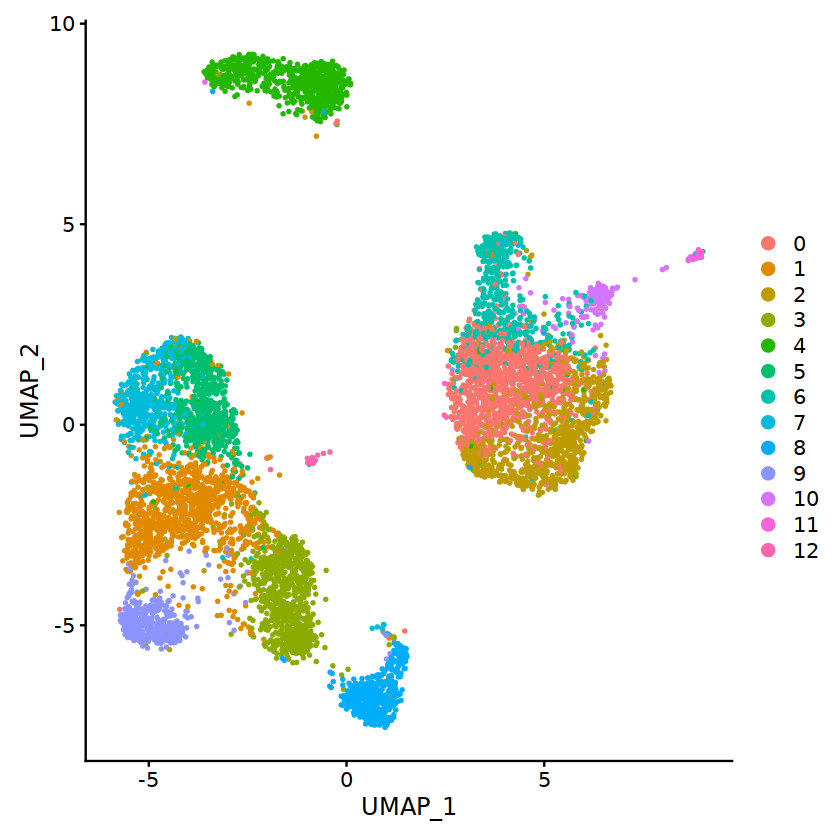

In [52]:
seurat_rds <- readRDS('10X_ATAC/analysis/atac_pbmc_10k_v1_S1_L001/Result/Analysis/atac_pbmc_10k_v1_S1_L001_scATAC_Object.rds')
chromVarResult <- mergeChromVarResult(seurat_rds, z_frame)

In [ ]:
chromVarResult$ATAC@meta.data

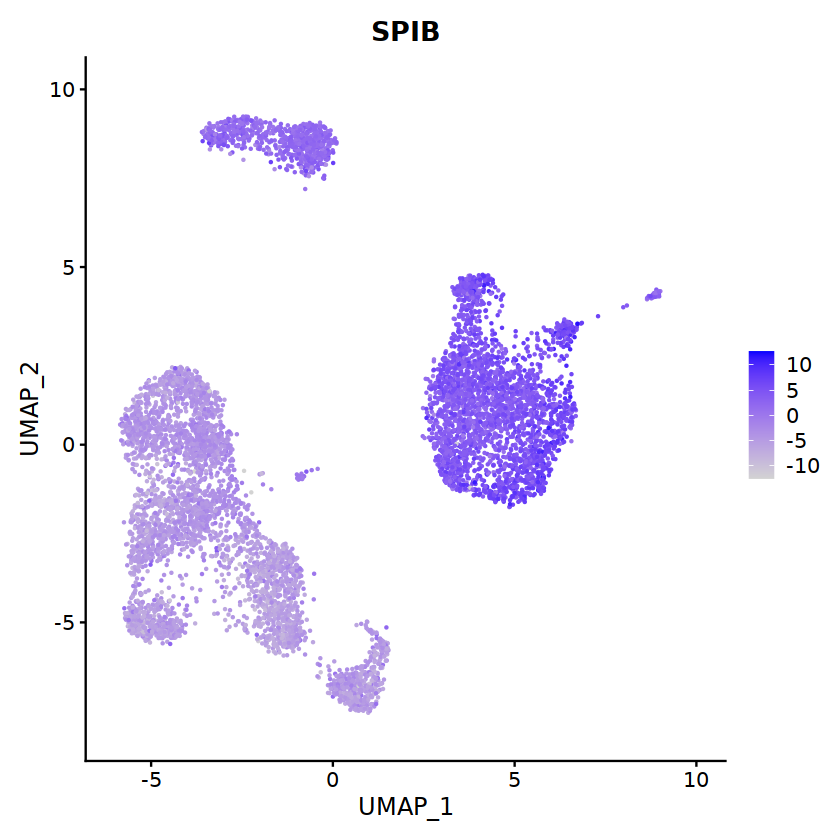

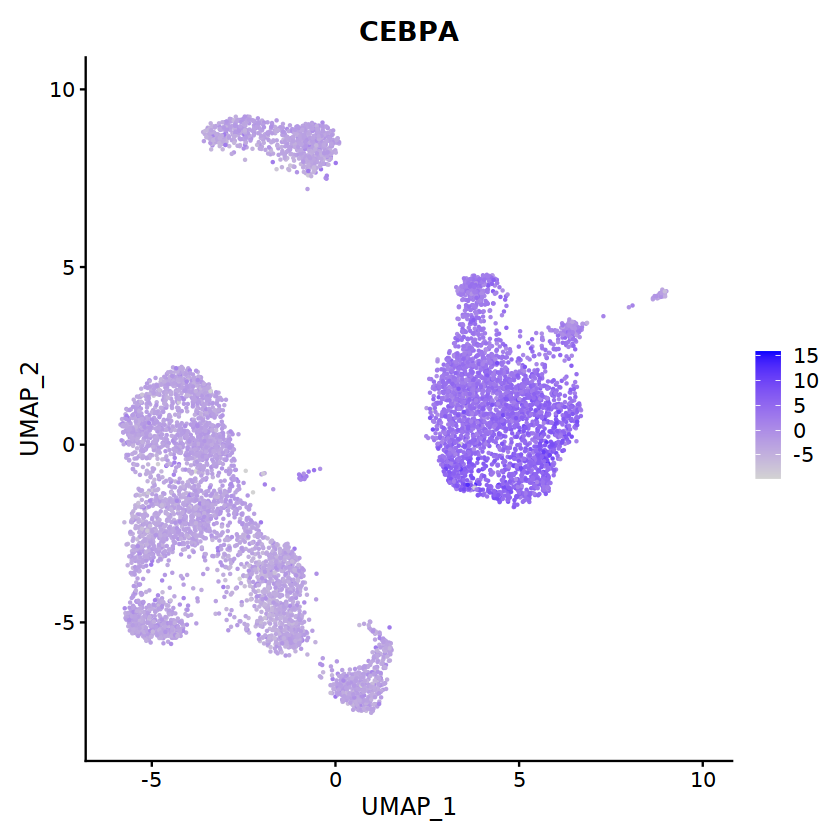

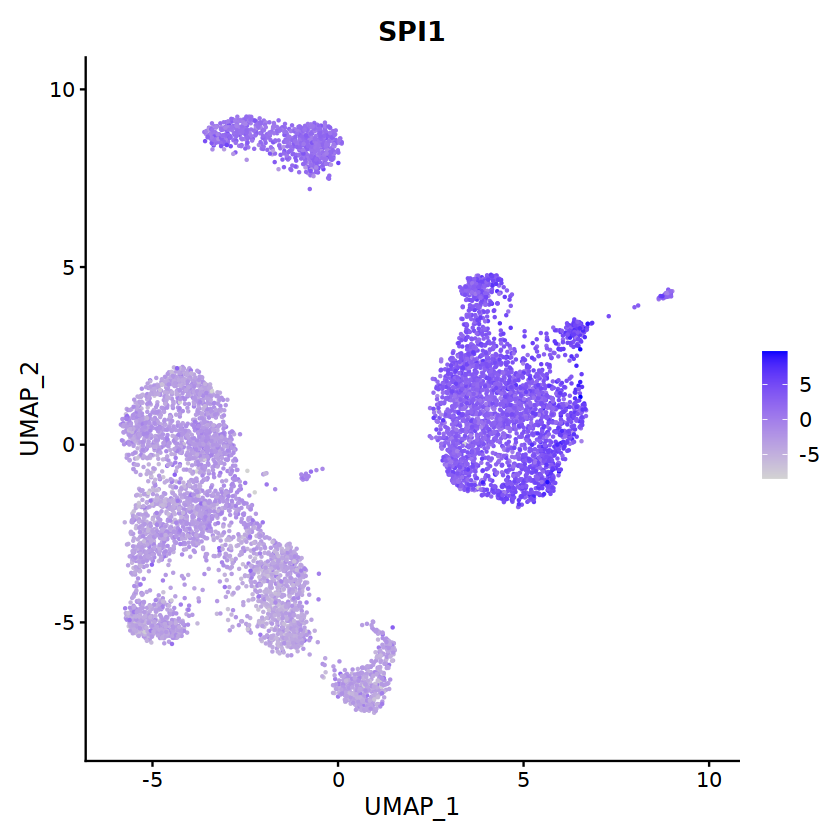

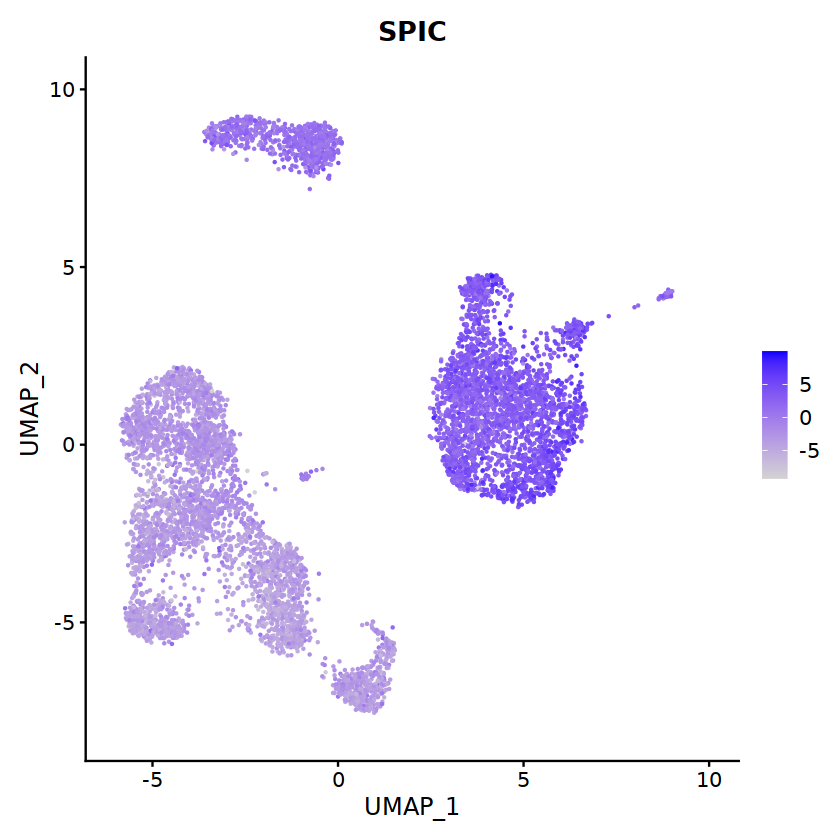

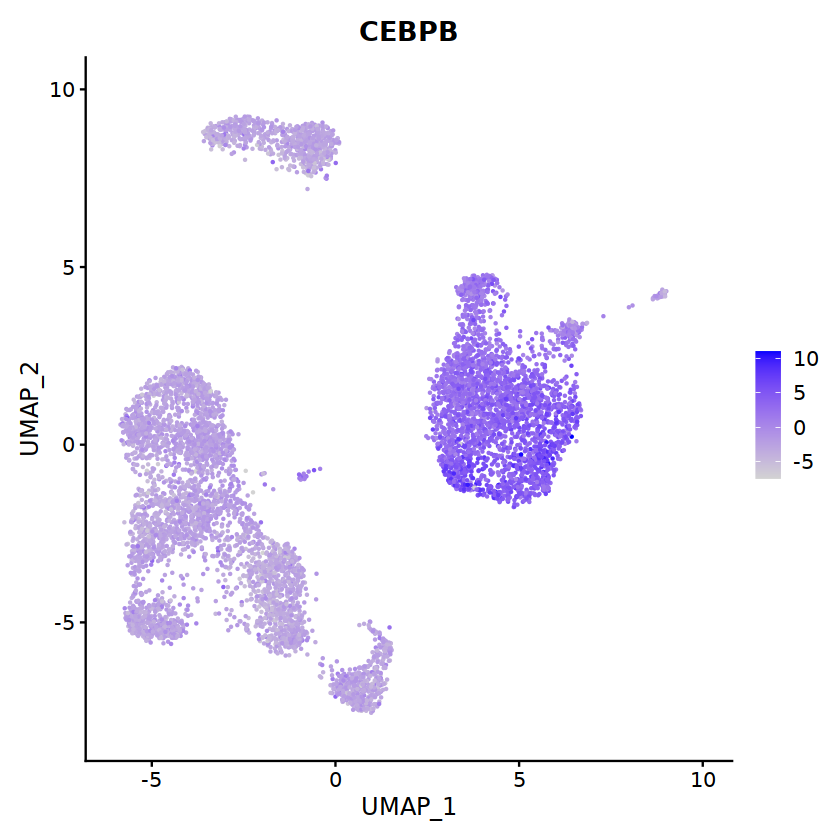

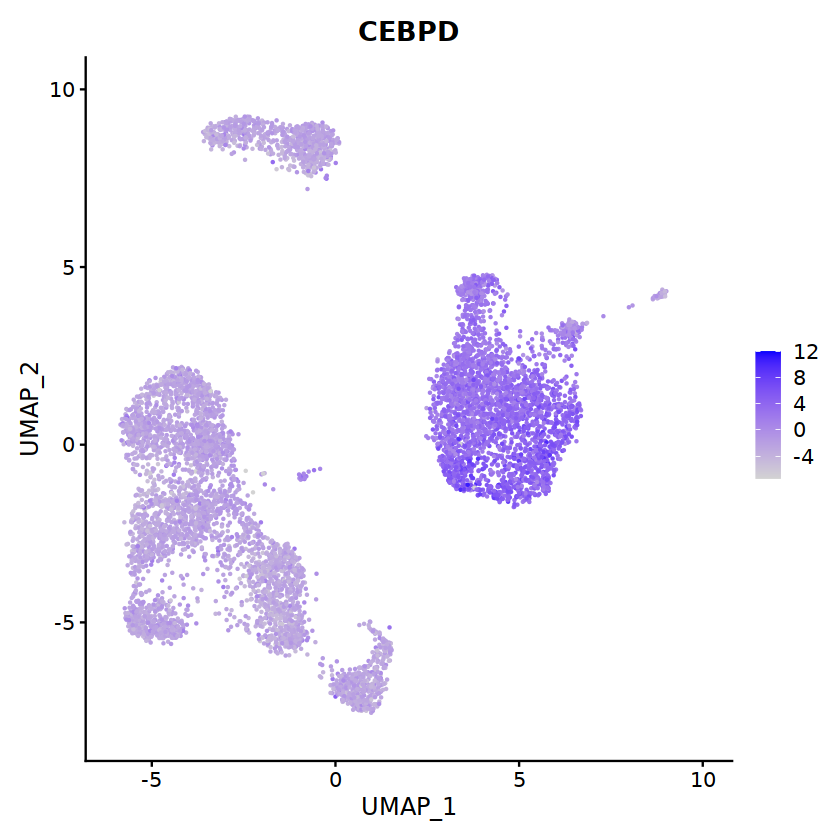

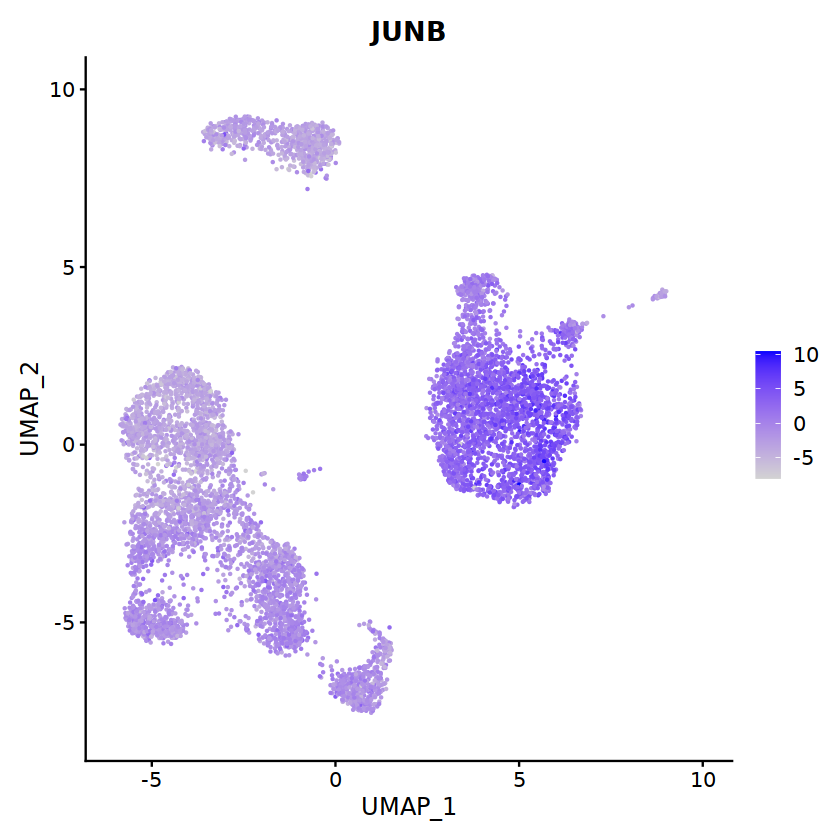

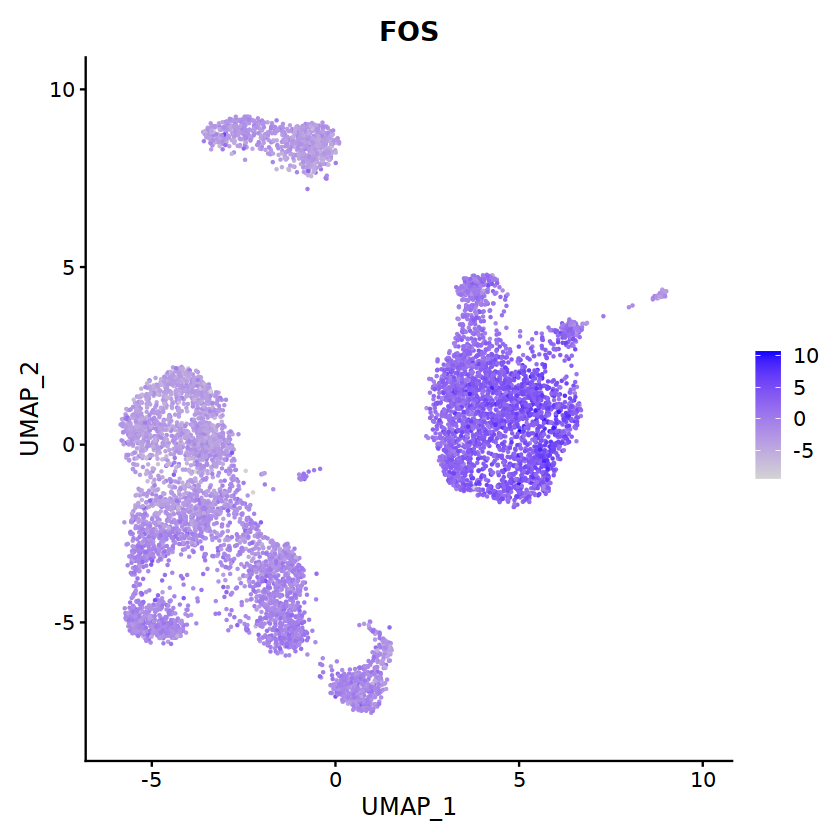

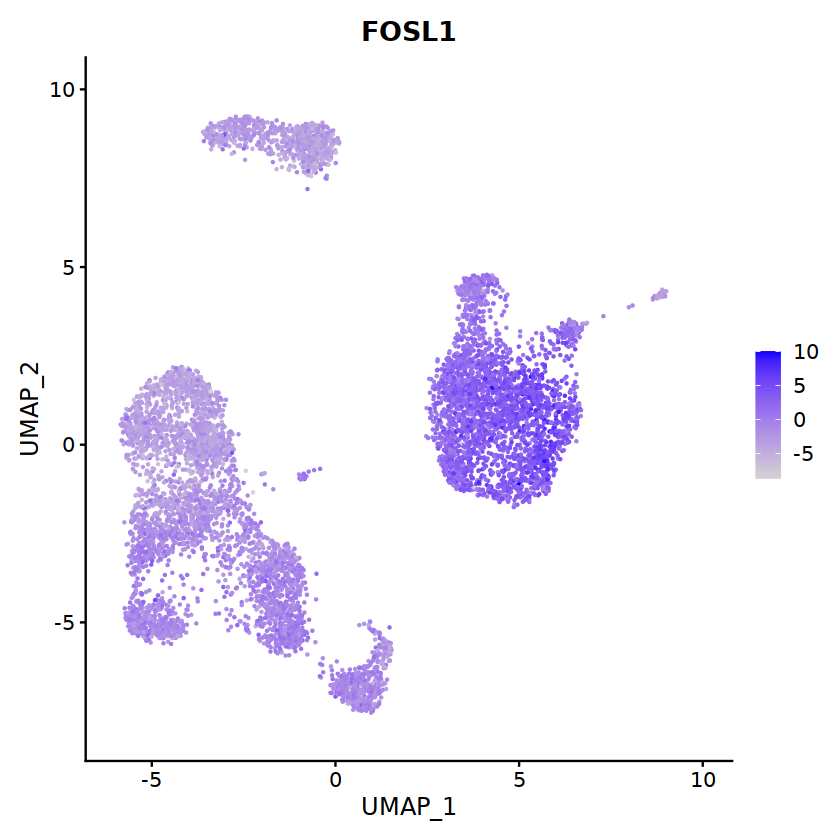

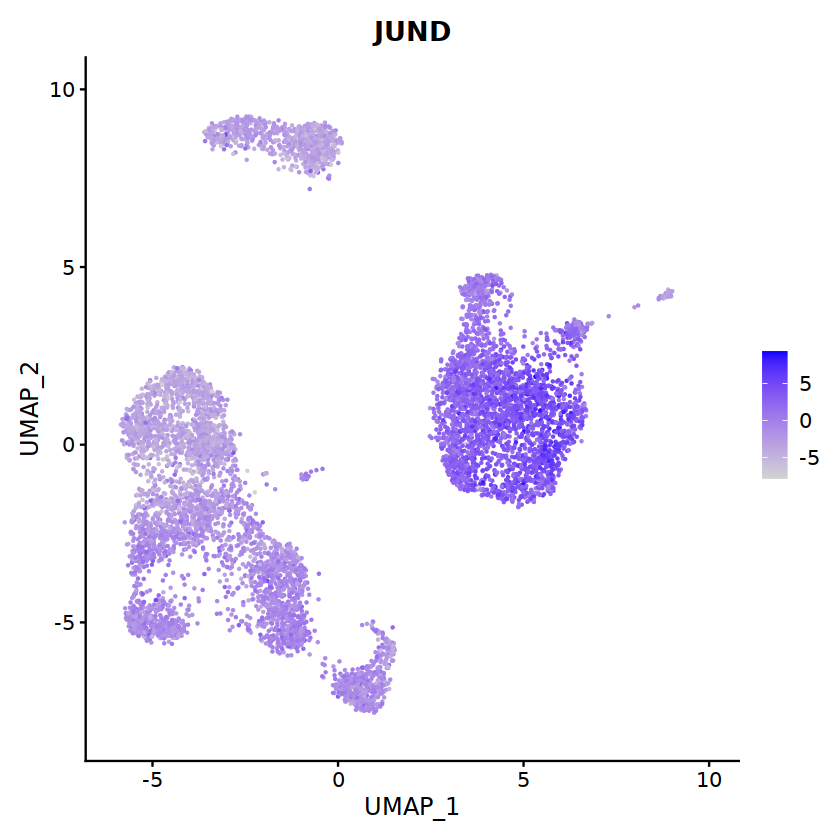

In [49]:
for (i in TFlist) {
    fig <- FeaturePlot(object = chromVarResult$ATAC, feature=i)
    show(fig)
}

In [ ]:
# tmp.path <- "10X_ATAC/chromVAR_result_more_motif.rds"
# tmp <- readRDS(tmp.path)
# qsave(tmp, str_replace(tmp.path, ".rds", ".qs"))

In [ ]:
qsave(chromVarResult, "10X_ATAC/chromVAR_result_more_motif.qs")

In [2]:
chromVarResult <- qread("example/10X_ATAC/chromVAR_result_more_motif.qs")

In [6]:
write.table(chromVarResult$z,'example/10X_ATAC/chromVar_result_table.txt', quote=FALSE, sep='\t')

In [14]:
HSMM_expr_matrix <- t(HSMM_expr_matrix)

In [9]:
HSMM_expr_matrix <- read.table("example/HSC/matrix.txt", header = FALSE, sep='\t')

In [17]:
HSMM_sample_sheet <- read.delim("example/HSC/result_10x/barcodes.tsv", header = FALSE)
HSMM_gene_annotation <- read.delim("example/HSC/result_10x/genes.tsv", header = FALSE)

ERROR: Error in load_cellranger_matrix("example/HSC/result_10x/"): 没有"load_cellranger_matrix"这个函数


In [23]:
pd <- new("AnnotatedDataFrame", data = HSMM_sample_sheet)
fd <- new("AnnotatedDataFrame", data = HSMM_gene_annotation)
HSMM <- newCellDataSet(as.matrix(HSMM_expr_matrix),
    phenoData = pd, featureData = fd)

ERROR: Error in `varLabels<-`(`*tmp*`, value = value[[2]]): number of new varLabels (2) should equal number of columns in AnnotatedDataFrame (1)


In [13]:
HSMM

ERROR: Error in eval(expr, envir, enclos): 找不到对象'HSMM'


In [ ]:

library(monocle3)
library(MAESTRO)
library(Seurat)
library(ggplot2)
library(dplyr)
setwd("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK")
TNK_Seurat=readRDS("CCA_TNK_repca_cluster.rds")
which(TNK_Seurat@meta.data$sample =="P08_OSF")
Idents(TNK_Seurat)=as.vector(unlist(Idents(TNK_Seurat)))
names(Idents(TNK_Seurat))=rownames(TNK_Seurat@meta.data)
which(names(Idents(TNK_Seurat)) != rownames(TNK_Seurat@meta.data) )

#CD8T_Seurat=subset(TNK_Seurat,idents=c(2,5,7,8,16,18,20,24,9,10))
index=which(as.vector(unlist(TNK_Seurat@meta.data$seurat_clusters)) %in% c(2,5,7,8,16,18,20,24,9,10))
#CD8T_Seurat=FindVariableFeatures(CD8T_Seurat,mean.cutoff=c(0.125,3),nfeatures=500)
#Idents(TNK_Seurat)[1:5]

#expmat=GetAssayData(CD8T_Seurat)[VariableFeatures(CD8T_Seurat),]
expmat=GetAssayData(TNK_Seurat)
cell_metadata=TNK_Seurat@meta.data[index,]
expmat=expmat[,index]
expmat=as.matrix(expmat)
index=which(rowMeans(expmat) > 0.0125)
expmat=expmat[index,]

gene_metadata=rownames(expmat)
gene_metadata=as.data.frame(gene_metadata)
rownames(gene_metadata)=rownames(expmat)
colnames(gene_metadata)="gene_short_name"

#combined the cytotoxic score and exhuasted score
cytotoxic_score=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Signature_score/Cytotoxic_score_CD8T.rds")
exhuasted_score=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Signature_score/Exhuastion_score_CD8T.rds")

#due to the error lable of p08
exhuasted_score$new_sample=exhuasted_score$sample
tumor_index=which(exhuasted_score$sample == "P08_OSF")
osf_index=which(exhuasted_score$sample == "P08_Tumor")
exhuasted_score$new_sample[tumor_index]="P08_Tumor"
exhuasted_score$new_sample[osf_index]="P08_OSF"
exhuasted_score$source=unlist(lapply(strsplit(exhuasted_score$new_sample,"_"),function(x) x[2]))
cell_id=unlist(lapply(strsplit(rownames(exhuasted_score),"@"),function(x) x[2]))
sample_cell=paste(exhuasted_score$new_sample,cell_id,sep = "@")
rownames(exhuasted_score)=sample_cell
rownames(cytotoxic_score)=sample_cell

cell_metadata=data.frame(cell_metadata,Exhuasted_score=as.vector(unlist(exhuasted_score$Exhuastion_HAVCR21)),Cytotoxic_score=as.vector(unlist(cytotoxic_score$Cytotoxic_GZMK1)))
#which(rownames(cell_metadata) != rownames(exhuasted_score))

cell_metadata$cancer_con=cell_metadata$source
cell_metadata$cancer_con[which(cell_metadata$cancer_con %in% c("OLK","OLP","OSF"))]="Precancerous"
colnames(expmat)=rownames(cell_metadata)
cds <- new_cell_data_set(expmat,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_metadata)

## Step 1: Normalize and pre-process the data
cds <- preprocess_cds(cds, num_dim = 100)
## Step 3: Reduce the dimensions using UMAP
cds <- reduce_dimension(cds,preprocess_method="PCA")
## Step 4: Cluster the cells
cds <- cluster_cells(cds)
## Step 5: Learn a graph
cds <- learn_graph(cds)

## Step 6: Order cells
get_earliest_principal_node <- function(cds, time_bin="Naïve CD8 T"){
  cell_ids <- which(colData(cds)[, "curated_anno"] == time_bin)
  
  closest_vertex <-
    cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
    igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
                                                              (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}
cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

setwd("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/Mean0125")
p=plot_cells(cds, label_groups_by_cluster=F,cell_size=0.5,color_cells_by = "curated_anno")+theme(legend.position="right",legend.title = element_blank())
ggsave("Monocle3_Differention_Traj_CD8T_cell_type.pdf",p,width = 5,height = 4)



p=plot_cells(cds, label_groups_by_cluster=F,cell_size=0.5,color_cells_by = "cytotoxic_score$Cytotoxic_GZMK1")+theme(legend.position="right",legend.title = element_blank())
ggsave("Monocle3_Differention_Traj_CD8T_cytotoxic_score.pdf",p,width = 5,height = 4)

p=plot_cells(cds, label_groups_by_cluster=F,cell_size=0.5,color_cells_by = "exhuasted_score$Exhuastion_HAVCR21")+theme(legend.position="right",legend.title = element_blank())
ggsave("Monocle3_Differention_Traj_CD8T_exhuasted_score.pdf",p,width = 5,height = 4)


p=plot_cells(cds, label_groups_by_cluster=F,cell_size=0.5,color_cells_by = "sample",show_trajectory_graph=F)+theme(legend.position="right",legend.title = element_blank())
ggsave("Monocle3_Differention_Traj_CD8T_sample.pdf",p,width = 5,height = 4)


p=plot_cells(cds, label_groups_by_cluster=F,cell_size=0.5,color_cells_by = "source",show_trajectory_graph=F)+theme(legend.position="right",legend.title = element_blank())
ggsave("Monocle3_Differention_Traj_CD8T_source.pdf",p,width = 5,height = 4)

p=plot_cells(cds, label_groups_by_cluster=F,cell_size=0.5,color_cells_by = "cancer_con",show_trajectory_graph=F)+theme(legend.position="right",legend.title = element_blank())
ggsave("Monocle3_Differention_Traj_CD8T_cancer_con.pdf",p,width = 5,height = 4)

p=plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

ggsave("Monocle3_Differention_Traj_CD8T_pseudotime.pdf",p,width = 5,height = 4)

saveRDS(cds,file="Monocel3_CD8T_trajectory_object.rds")
```



#infer the differention trajectory lineage by Monocle2
```{r}
library(monocle)
library(MAESTRO)
library(Seurat)
library(ggplot2)
library(dplyr)
setwd("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK")
TNK_Seurat=readRDS("CCA_TNK_repca_cluster.rds")

TNK_Seurat@meta.data$sample[81017,]
which(TNK_Seurat@meta.data$sample =="P08_OSF")


#CD8T_Seurat=subset(TNK_Seurat,idents=c(2,5,7,8,16,18,20,24,9,10))
index=which(as.vector(unlist(TNK_Seurat@meta.data$seurat_clusters)) %in% c(2,5,7,8,16,18,20,24,9,10))

#CD8T_Seurat=FindVariableFeatures(CD8T_Seurat,mean.cutoff=c(0.125,3),nfeatures=500)
#Idents(TNK_Seurat)[1:5]

#expmat=GetAssayData(CD8T_Seurat)[VariableFeatures(CD8T_Seurat),]
#DefaultAssay(TNK_Seurat)<-"RNA"
expmat=GetAssayData(TNK_Seurat)
cell_metadata=TNK_Seurat@meta.data[index,]
expmat=expmat[,index]
#cell_metadata=Myeloid_Seurat@meta.data

expmat=as.matrix(expmat)
index=which(rowMeans(expmat) > 0)
length(index)
expmat=expmat[index,]





gene_metadata=rownames(expmat)
gene_metadata=as.data.frame(gene_metadata)
rownames(gene_metadata)=rownames(expmat)
colnames(gene_metadata)="gene_short_name"

#combined the cytotoxic score and exhuasted score
#cytotoxic_score=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Signature_score/Cytotoxic_score_CD8T.rds")
#exhuasted_score=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Signature_score/Exhuastion_score_CD8T.rds")

#due to the error lable of p08
exhuasted_score$new_sample=exhuasted_score$sample
tumor_index=which(exhuasted_score$sample == "P08_OSF")
osf_index=which(exhuasted_score$sample == "P08_Tumor")
exhuasted_score$new_sample[tumor_index]="P08_Tumor"
exhuasted_score$new_sample[osf_index]="P08_OSF"
exhuasted_score$source=unlist(lapply(strsplit(exhuasted_score$new_sample,"_"),function(x) x[2]))
cell_id=unlist(lapply(strsplit(rownames(exhuasted_score),"@"),function(x) x[2]))
sample_cell=paste(exhuasted_score$new_sample,cell_id,sep = "@")
rownames(exhuasted_score)=sample_cell
rownames(cytotoxic_score)=sample_cell

cell_metadata=data.frame(cell_metadata,Exhuasted_score=as.vector(unlist(exhuasted_score$Exhuastion_HAVCR21)),Cytotoxic_score=as.vector(unlist(cytotoxic_score$Cytotoxic_GZMK1)))
#which(rownames(cell_metadata) != rownames(exhuasted_score))

cell_metadata$cancer_con=cell_metadata$source
cell_metadata$cancer_con[which(cell_metadata$cancer_con %in% c("OLK","OLP","OSF"))]="Precancerous"
colnames(expmat)=rownames(cell_metadata)

pd <- new("AnnotatedDataFrame", data = cell_metadata)
fd <- new("AnnotatedDataFrame", data = gene_metadata)

#cds <- newCellDataSet(expmat, phenoData = pd, featureData = fd)
colnames(expmat)=rownames(cell_metadata)

cds <- newCellDataSet(as(expmat, "sparseMatrix"),
                phenoData = pd,
                featureData = fd)



setwd("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/")





#disp_table <- dispersionTable(cds)
#ordering_genes <- subset(disp_table, mean_expression >= 0.05)
cds <- estimateSizeFactors(cds)
cds=estimateDispersions(cds)
cds <- setOrderingFilter(cds, ordering_genes)
cds <- reduceDimension(cds)
saveRDS(cds,file="/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/AssayRNA_more0_monocle.rds")

cds=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/AssayRNA_more0_monocle.rds")
cds=ds
cds <- orderCells(cds)
plot_cell_trajectory(cds, color_by = "curated_anno")
#cds <- clusterCells(cds, num_clusters = 3)

#setwd("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/Monocle_Mean0125")

cds=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/Monocle2_relative2abs/CD8T_Monocle2_traject_cds.rds")

p=plot_cell_trajectory(cds, color_by = "curated_anno",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_cell_type.pdf",p,width = 5,height = 4)

p=plot_cell_trajectory(cds, color_by = "curated_anno_gene",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_curated_anno_gene.pdf",p,width = 8,height = 4)

p=plot_cell_trajectory(cds, color_by = "Pseudotime",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_pseudotime.pdf",p,width = 5,height = 4)

p=plot_cell_trajectory(cds, color_by = "Pseudotime",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_pseudotime.pdf",p,width = 5,height = 4)

p=plot_cell_trajectory(cds, color_by = "Cytotoxic_score",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_Cytotoxic_score.pdf",p,width = 5,height = 4)
p=plot_cell_trajectory(cds, color_by = "Exhuasted_score",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_Exhuasted_score.pdf",p,width = 5,height = 4)
p=plot_cell_trajectory(cds, color_by = "State",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F)
ggsave("Monocle3_Differention_Traj_CD8T_State.pdf",p,width = 5,height = 4)

p=plot_cell_trajectory(cds, color_by = "curated_anno",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F) +
    facet_wrap(~curated_anno, nrow = 1)
ggsave("Monocle3_Differention_Traj_CD8T_cell_type_split.pdf",p,width = 5,height = 4)

p=plot_cell_trajectory(cds, color_by = "source",cell_size=0.5,show_tree = F,show_backbone=F,show_branch_points=F) +
    facet_wrap(~source, nrow = 1)
ggsave("Monocle3_Differention_Traj_CD8T_source_split.pdf",p,width = 7,height = 4)

saveRDS(cds,file="Monocel2_CD8T_trajectory_object.rds")

cds=readRDS("/mnt/Storage2/home/hanya/project/Carcinogenesis/scRNAseq/Without_P12OLP/CCA_result/Nfeatures5000_includingInteract_CCA/Seperate_cell_lineage/TNK/Differeential_trajectory/Monocle_Mean0125/Monocel2_CD8T_HVGS2000_trajectory_object.rds")




#数量级不成正比，所以如果
     
index=which(colMeans(expmat[c(match("CD8A",rownames(expmat)),match("CD8B",rownames(expmat))),]) ==0 )
#i=only 914 point will not signaficant influence on the result


# Mouse Brain

## ATAC-seq

In [2]:
mouse.brain.peak <- Read10X_h5('GSE140203_SHARE_seq/data//brain/ATAC/peak_count.h5')
# mouse.brain.peak <- mouse.brain.peak[which(Matrix::rowSums(mouse.brain.peak)>50),]

In [3]:
mouse.brain.gene <- ATACCalculateGenescore(mouse.brain.peak,organism = 'GRCm38')

In [5]:
mouse.brain.gene

   [[ suppressing 32 column names ‘R1.01.R2.04.R3.55.P1.40’, ‘R1.01.R2.05.R3.35.P1.40’, ‘R1.01.R2.08.R3.45.P1.39’ ... ]]

   [[ suppressing 32 column names ‘R1.01.R2.04.R3.55.P1.40’, ‘R1.01.R2.05.R3.35.P1.40’, ‘R1.01.R2.08.R3.45.P1.39’ ... ]]

   [[ suppressing 32 column names ‘R1.01.R2.04.R3.55.P1.40’, ‘R1.01.R2.05.R3.35.P1.40’, ‘R1.01.R2.08.R3.45.P1.39’ ... ]]



26214 x 3293 sparse Matrix of class "dgCMatrix"
                                                                                            
0610005C13Rik  .            1.583519e-03 .            1.398580e-04 .            .           
0610009B22Rik  .            1.983806e+00 .            .            .            .           
0610009E02Rik  .            6.529229e-02 .            2.450646e-04 9.584333e-01 .           
0610009L18Rik  .            3.467014e-01 .            7.432259e-02 .            2.168233e-01
0610010F05Rik  .            .            .            .            .            .           
0610010K14Rik  .            .            .            .            .            .           
0610012G03Rik  .            2.943593e-01 .            6.550505e-02 .            .           
0610030E20Rik  .            1.178100e-04 .            .            1.178100e-04 .           
0610031O16Rik  .            .            .            .            .            .           
0610038B21Rik  .      

In [16]:
mouse.brain.ATAC.res <- ATACRunSeurat(inputMat = mouse.brain.peak , 
                                project = "GSE140203_SHARE_seq/brain/ATAC/mouse_brain_scATAC", 
                                method = "LSI",
                                min.c = 10,
                                min.p = 50,
                                dims.use = 1:30,
                                cluster.res = 0.6,
                                peaks.test.use = "presto",
                                peaks.cutoff = 1e-05)



Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
LSI analysis ...

Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

UMAP analysis ...

14:28:25 UMAP embedding parameters a = 0.9922 b = 1.112

14:28:25 Read 3293 rows and found 30 numeric column

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3293
Number of edges: 105133

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7781
Number of communities: 7
Elapsed time: 0 seconds


Identify cluster specific peaks ...



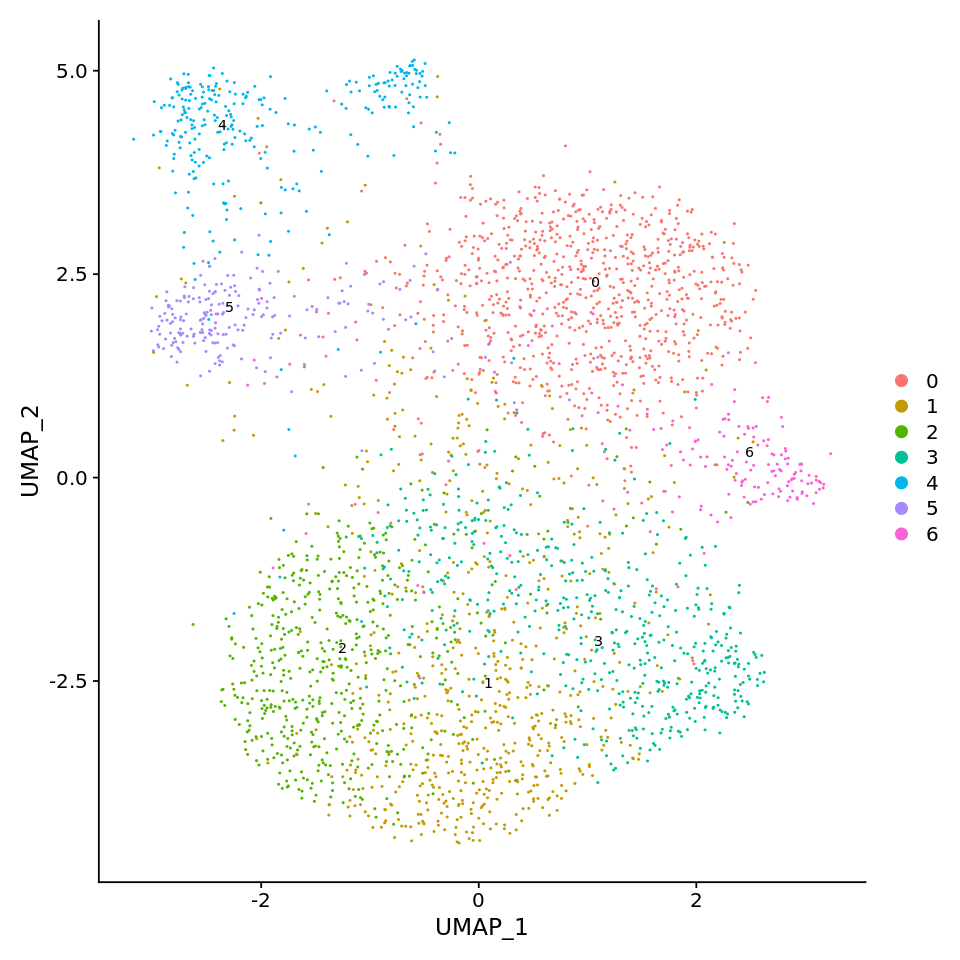

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(mouse.brain.ATAC.res$ATAC, label = TRUE, pt.size = 0.2, label.size = 3, repel = T)

In [19]:
mouse.brain.ATAC.res$ATAC <- ATACAttachGenescore(mouse.brain.ATAC.res$ATAC, mouse.brain.gene)

mouse.brain.ATAC.res$ATAC <- ATACAnnotateCelltype(mouse.brain.ATAC.res$ATAC, 
                                                  signatures = "mouse.brain.ALLEN", 
                                                  min.score = 0.1, 
                                                  genes.test.use = "presto", 
                                                  genes.cutoff = 1E-5)

Centering and scaling data matrix

Identify cluster specific genes based on RP score ...



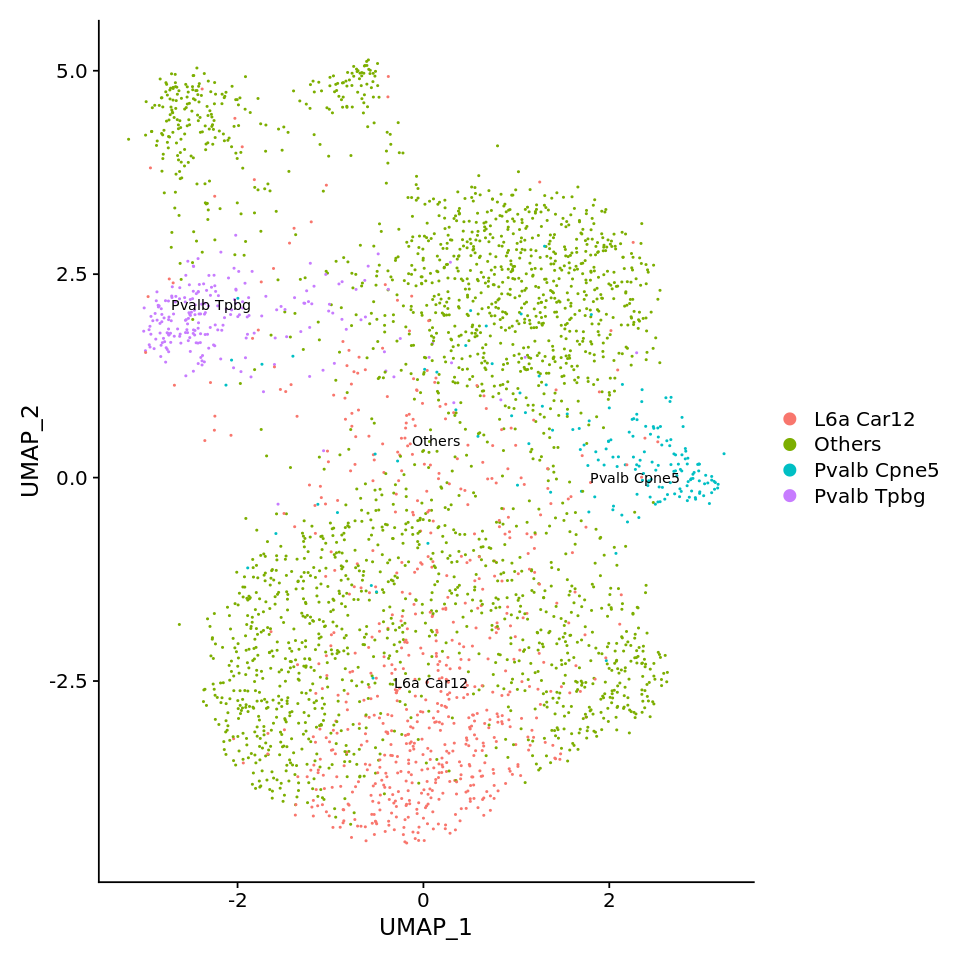

In [32]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(mouse.brain.ATAC.res$ATAC, label = TRUE, pt.size = 0.2, label.size = 3, repel = T, group.by = 'assign.ident')

In [21]:
qsave(mouse.brain.ATAC.res, "GSE140203_SHARE_seq/brain/ATAC/mouse_brain_scATAC.qs", nthreads = 2)

In [ ]:
mouse.brain.ATAC.res <- qread("GSE140203_SHARE_seq/brain/ATAC/mouse_brain_scATAC.qs")

In [23]:
mouse.brain.singlecell.experiment <- as.SingleCellExperiment(mouse.brain.ATAC.res$ATAC)
saveRDS(mouse.brain.singlecell.experiment, "GSE140203_SHARE_seq/brain/ATAC/mouse_brain_scATAC_singlecellexperiment.rds")

## RNA-seq

In [20]:
mouse.brain.rna.count <- read.table('GSE140203_SHARE_seq/data/brain/RNA/GSM4156610_brain.rna.counts.txt', sep = "\t", header = TRUE,row.names = 'gene')

In [23]:
qsave(mouse.brain.rna.count, 'GSE140203_SHARE_seq/brain/RNA/count.qs')

In [26]:
mouse.brain.rna.count <- qread('GSE140203_SHARE_seq/brain/RNA/count.qs')

In [29]:
mouse.brain.rna.count

R1.01.R2.01.R3.24.P1.40 R1.01.R2.04.R3.55.P1.40
0610007P14Rik 0                       0                      
0610009B22Rik 0                       0                      
0610009L18Rik 0                       0                      
0610009O20Rik 0                       0                      
0610010F05Rik 2                       0                      
0610010K14Rik 0                       0                      
0610011F06Rik 0                       0                      
0610012D04Rik 0                       0                      
0610012G03Rik 0                       0                      
0610025J13Rik 0                       0                      
0610030E20Rik 0                       0                      
0610037L13Rik 1                       0                      
0610038B21Rik 0                       0                      
0610039K10Rik 0                       0                      
0610040B10Rik 0                       0                      
0610040F04Rik 1                       0                      
0610040J01Rik 0                       0                      
0610043K17Rik 0                       0                      
1110001J03Rik 0                       0                      
1110002E22Rik 0                       0                      
1110002J07Rik 0                       0                      
1110002L01Rik 0                       0                      
1110004E09Rik 0                       0                      
1110004F10Rik 0                       0                      
1110006O24Rik 0                       0                      
1110008F13Rik 0                       0                      
1110008L16Rik 0                       0                      
1110008P14Rik 0                       0                      
1110012L19Rik 0                       0                      
1110015O18Rik 0                       0                      
⋮             ⋮                       ⋮                      
Zscan2        0                       0                      
Zscan20       0                       0                      
Zscan21       0                       0                      
Zscan22       0                       0                      
Zscan25       0                       0                      
Zscan26       0                       0                      
Zscan29       0                       0                      
Zscan30       0                       0                      
Zscan4d       0                       0                      
Zscan5b       0                       0                      
Zswim1        0                       0                      
Zswim2        0                       0                      
Zswim3        0                       0                      
Zswim4        0                       0                      
Zswim5        0                       0                      
Zswim6        1                       1                      
Zswim7        0                       0                      
Zswim8        0                       0                      
Zufsp         0                       0                      
Zw10          0                       0                      
Zwilch        0                       0                      
Zwint         0                       0                      
Zxdb          0                       0                      
Zxdc          0                       0                      
Zyg11a        0                       0                      
Zyg11b        0                       1                      
Zyx           0                       0                      
Zzef1         0                       0                      
Zzz3          0                       0                      
l7Rn6         0                       0                      
              R1.01.R2.05.R3.35.P1.40 R1.01.R2.08.R3.24.P1.40
0610007P14Rik 0                       0                      
0610009B22Rik 0                       0       

In [27]:
mouse.brain.rna.expr <- RNACountToTPM(mouse.brain.rna.count, idType = "Symbol", organism = "GRCm38")

Warning message in RNACountToTPM(mouse.brain.rna.count, idType = "Symbol", organism = "GRCm38"):
“Omit 855 genes of which length is not available !”


In [ ]:
?RNACountToTPM

In [32]:
qsave(mouse.brain.rna.expr, 'GSE140203_SHARE_seq/brain/RNA/tpm.qs')

In [28]:
# bcc <- Read10X_h5('BCC_GSE129785/GSE123813_BCC_scRNA_counts.h5')
# bcc.expr <- RNACountToTPM(bcc, idType = "Symbol")
mouse.brain.rna.expr <- log2(mouse.brain.rna.expr/10+1)
mouse.brain.RNA.res <- RNARunSeurat(inputMat = mouse.brain.rna.expr, 
                              project = "GSE140203_SHARE_seq/brain/RNA/mouse_brain_scRNA", 
                              min.c = 10,
                              min.g = 500,
                              dims.use = 1:15,
                              variable.genes = 2000, 
                              organism = "GRCm38",
                              cluster.res = 0.6,
                              genes.test.use = "presto",
                              genes.cutoff = 1e-05)
data(mouse.brain.ALLEN)
mouse.brain.RNA.res$RNA <- RNAAnnotateCelltype(RNA = mouse.brain.RNA.res$RNA, 
                                         gene = mouse.brain.RNA.res$gene,
                                         signatures = mouse.brain.ALLEN, 
                                         min.score = 0.05)

Normalization and identify variable genes ...

Regressing out nCount_RNA

Centering and scaling data matrix

PCA analysis ...

PC_ 1 
Positive:  Camk2a, Arpp21, Gm28928, Snhg11, R3hdm1, Mef2c, Meg3, Homer1, Neto1, Trank1 
	   Phf24, Fnbp1l, Atp2b1, Snap25, Nptn, Flrt2, Wasf1, Trim9, Gls, Dync1i2 
	   Miat, Syt7, Nrgn, 3110039M20Rik, Shank1, Celf5, Plppr4, Rtn3, Abi2, A830036E02Rik 
Negative:  Plp1, Cbln3, Gabra6, Gjc3, Gatm, Car2, Glul, Ptgds, Scd2, Zic1 
	   Cbln1, Atp1b2, Neurod1, Abca2, Nkx2-2os, Sox2, Btg1, Arrdc3, S1pr1, Apoe 
	   Tubb4a, Zic2, Fth1, Cst3, Asphd1, Olig1, Tmem229a, Kcnc3, Olig2, Cdkn1b 
PC_ 2 
Positive:  Arpp21, Zeb2, Gm28928, Homer1, R3hdm1, Slc17a7, Nrgn, Atp1a1, Mef2c, Atp2b1 
	   Plp1, Gatm, Spred1, Wasf1, Plk2, A830036E02Rik, Camk2a, Xist, Kcnv1, Olfm1 
	   Camk2n1, Enc1, Lmo4, 3110039M20Rik, Gjc3, Gm27017, Cbln3, Glul, Neto1, Ptgds 
Negative:  Rmst, 5330434G04Rik, Peg3, Ece2, Tnrc6a, Mirg, Coro6, Amy1, Gm38393, Hspa4l 
	   Ccdc136, Atp1a3, Snhg11, Rnpc3, Wsb1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3568
Number of edges: 118534

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7800
Number of communities: 8
Elapsed time: 0 seconds


Identify cluster specific genes ...



Warning message in data(mouce.brain.ALLEN):
“data set ‘mouce.brain.ALLEN’ not found”


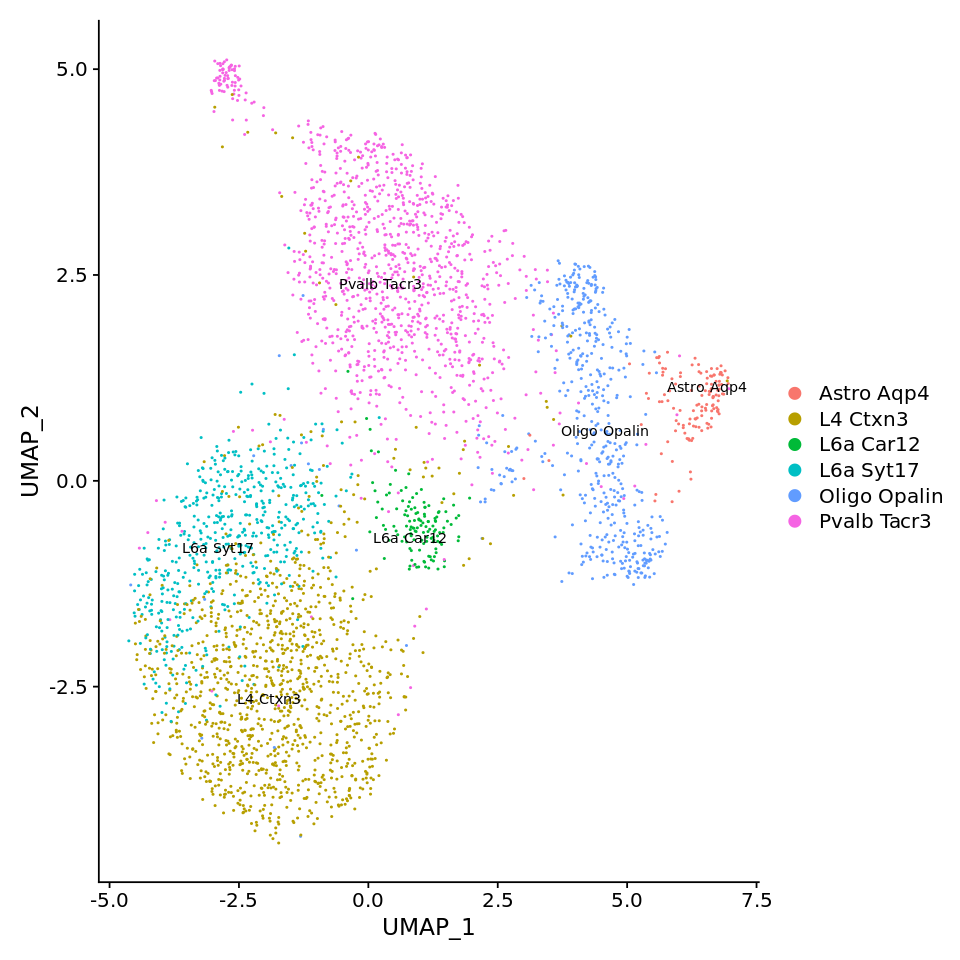

In [29]:
DimPlot(mouse.brain.RNA.res$RNA, label = TRUE, pt.size = 0.2, label.size = 3, repel = T, group.by = 'assign.ident')

In [31]:
qsave(mouse.brain.RNA.res, 'GSE140203_SHARE_seq//brain//RNA/seurat.qs')

In [36]:
dim(result.RP.filter)

[1] 28307  2569

In [34]:
result.RP.filter <- result.RP[, which(colnames(result.RP) %in% rownames(result$ATAC@meta.data)), drop=F]

In [59]:
peak_count_matrix = Read10X_h5('example/small_HSC/GSE96772_HSC_merged_count_dedup.h5')

In [61]:
colnames(peak_count_matrix)

[1] "singles-BM0828-CMP-frozen-1511"    "BM1077-CMP-Frozen-160106-3"       
   [3] "singles-20160617-scATAC-BM1077"    "singles-160818-BM1137-pDC-LS-7"   
   [5] "singles-20160617-scATAC-BM1077.1"  "singles-BM0828-HSC-fresh-15102"   
   [7] "singles-PB1022-mono-160128-36"     "singles-160822-BM1137-CMP-LS-1"   
   [9] "singles-BM1214-GMP-160421-53"      "singles-20160726-scATAC-BM1137"   
  [11] "singles-BM0828-MPP-frozen-1511"    "singles-BM0828-LMPP-frozen-151"   
  [13] "singles-BM0828-GMP-151027-68"      "singles-160809-scATAC-BM1137-G"   
  [15] "singles-BM0106-HSC-LS-160219-6"    "singles-MEP-141017-90"            
  [17] "singles-MEP-141017-95"             "singles-BM0828-CMP-frozen-1511.1" 
  [19] "singles-BM1214-MCP-frozen-1601"    "singles-BM1214-GMP-160421-81"     
  [21] "BM1077-MPP-Frozen-160105-60"       "singles-BM0828-LMPP-frozen-151.1" 
  [23] "BM1077-MEP-Frozen-160107-9"        "BM1077-HSC-Frozen-160105-6"       
  [25] "singles-BM0106-UNK-160418-63"      "BM1077-CLP-Frozen-160106-38"      
  [27] "singles-BM0828-LMPP-frozen-151.2"  "singles-BM0828-CLP-frozen-1511"   
  [29] "singles-BM0828-LMPP-frozen-151.3"  "singles-BM0828-MEP-160420-51"     
  [31] "singles-20160726-scATAC-BM1137.1"  "singles-BM0106-UNK-160418-55"     
  [33] "singles-20160617-scATAC-BM1214"    "singles-BM0106-HSC-SIM-160219-"   
  [35] "singles-BM1214-GMP-160421-48"      "singles-BM1214-GMP-160421-22"     
  [37] "singles-BM0828-GMP-151027-40"      "singles-20160726-scATAC-BM1214"   
  [39] "singles-BM0828-CLP-frozen-1511.1"  "singles-160818-BM1137-pDC-LS-6"   
  [41] "singles-BM0828-MEP-160420-7"       "singles-20160726-scATAC-BM1214.1" 
  [43] "singles-160818-BM1137-pDC-LS-9"    "singles-160808-scATAC-BM1137-G"   
  [45] "singles-160819-BM1137-CMP-LS-4"    "singles-160808-scATAC-BM1137-G.1" 
  [47] "singles-PB1022-mono-160128-40"     "singles-BM0106-HSC-SIM-160219-.1" 
  [49] "singles-160819-BM1137-CMP-LS-6"    "singles-PB1022-mono-160128-24"    
  [51] "BM1077-HSC-Frozen-160105-87"       "BM1077-HSC-Frozen-160105-27"      
  [53] "singles-BM0828-CMP-frozen-1511.2"  "singles-160808-scATAC-BM1137-G.2" 
  [55] "singles-160809-scATAC-BM1137-G.1"  "BM1077-HSC-Frozen-160105-20"      
  [57] "singles-BM0828-MPP-frozen-1511.1"  "singles-BM0828-LMPP-frozen-151.4" 
  [59] "singles-BM0828-CLP-frozen-1511.2"  "singles-20160617-scATAC-BM1077.2" 
  [61] "singles-BM1214-MCP-frozen-1601.1"  "singles-160809-scATAC-BM1137-G.2" 
  [63] "singles-160808-scATAC-BM1137-G.3"  "BM1077-MEP-Frozen-160107-1"       
  [65] "singles-20160617-scATAC-BM1077.3"  "BM1077-HSC-Frozen-160105-62"      
  [67] "singles-20160617-scATAC-BM1077.4"  "singles-BM0828-MEP-160420-95"     
  [69] "singles-BM0828-CLP-frozen-1511.3"  "singles-BM0828-GMP-151027-61"     
  [71] "singles-BM0828-GMP-151027-24"      "singles-BM0828-HSC-fresh-15102.1" 
  [73] "singles-BM0106-HSC-LS-160219-4"    "singles-20160726-scATAC-BM1137.2" 
  [75] "singles-BM0106-HSC-SIM-160219-.2"  "singles-BM1214-GMP-160421-64"     
  [77] "singles-20160726-scATAC-BM1137.3"  "singles-BM0828-MEP-160420-82"     
  [79] "singles-160822-BM1137-CMP-LS-4"    "singles-20160726-scATAC-BM1137.4" 
  [81] "singles-20160726-scATAC-BM1214.2"  "singles-BM0828-LMPP-frozen-151.5" 
  [83] "singles-BM0106-UNK-160418-56"      "BM1077-CLP-Frozen-160106-85"      
  [85] "singles-160818-BM1137-pDC-LS-9.1"  "BM1077-HSC-Frozen-160105-7"       
  [87] "singles-160809-scATAC-BM1137-G.3"  "singles-20160617-scATAC-BM1214.1" 
  [89] "singles-BM0106-HSC-SIM-160219-.3"  "singles-BM0106-UNK-160418-36"     
  [91] "singles-160819-BM1137-CMP-LS-1"    "singles-BM1214-MCP-frozen-1601.2" 
  [93] "singles-160808-scATAC-BM1137-G.4"  "BM1077-CLP-Frozen-160106-3"       
  [95] "singles-BM0106-UNK-160418-1"       "singles-160822-BM1137-CMP-LS-9"   
  [97] "singles-20160617-scATAC-BM1214.2"  "singles-BM0828-MEP-160420-94"     
  [99] "singles-20160726-scATAC-BM1214.3"  "BM1077-CLP-Frozen-160106-82"      
 [101] "singles-BM0106-HSC-SIM-160219-.4"  "singles-P

In [58]:
gene.id = rownames(peak_count_matrix)
write10xCounts(
  'example/small_HSC/GSE96772_HSC_merged_count_dedup.h5',
  peak_count_matrix,
  barcodes = colnames(peak_count_matrix),
  gene.id = rownames(peak_count_matrix),
  gene.symbol = gene.id,
  gene.type = "Gene Expression",
  overwrite = FALSE,
  type = "HDF5",
  genome = "hg38",
  version = "3",
  chemistry = "Single Cell 3' v3",
  original.gem.groups = 1L,
  library.ids = "custom"
)

You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.

You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.



In [62]:
result <- ATACRunSeurat(inputMat = peak_count_matrix , 
                                project = "example/small_HSC/ATAC", 
                                method = "LSI",
                                min.c = 50,
                                min.p = 500,
                                dims.use = 1:30,
                                cluster.res = 0.6,
                                peaks.test.use = "presto",
                                peaks.cutoff = 1e-05)
result.RP <- ATACCalculateGenescore(inputMat = peak_count_matrix)
result$ATAC <- ATACAttachGenescore(result$ATAC, result.RP)
result$ATAC <- ATACAnnotateCelltype(result$ATAC, 
                                        signatures = "human.immune.CIBERSORT", 
                                        min.score = 0, 
                                        genes.test.use = "presto", 
                                        genes.cutoff = 1E-5, 
                                        orig.ident = NULL)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
LSI analysis ...

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

UMAP analysis ...

23:59:14 UMAP embedding parameters a = 0.9922 b = 1.112

23:59:14 Read 2592 rows and found 30 numeric columns

23:59:14 Using Annoy for neighbor search, n_neighbors = 30

23:59:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:59:20 Writing NN index file to temp file /tmp/RtmpWijuBe/file285268807fe7

23:59:20 Searching Annoy index using 1 thread, search_k = 3000

23:59:21 Annoy recall = 100%

23:59:26 Commencing smooth kNN distance calibration using 1 thread

23:59:33 Initializing from normalized Laplacian + noise

23:59:33 Commencing optimization for 500 epochs, with 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2592
Number of edges: 72529

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8523
Number of communities: 12
Elapsed time: 0 seconds


Identify cluster specific peaks ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Centering and scaling data matrix

Identify cluster specific genes based on RP score ...

The following `from` values were not present in `x`: ActDCs, ActMast, ActMemCD4Tcells, ActNK, ActpDCs, CD8Tcells, CD8Tex, Endothelial, Eosinophils, Fibroblasts, MacrophagesM0, MacrophagesM2, Myofibroblasts, NaiveCD4Tcells, PlasmaCells, RestDCs, RestMast, RestMemCD4Tcells, RestNK, RestpDCs, Tfh, TMKI67, Treg



In [63]:
single_cell_exper <- as.SingleCellExperiment(result$ATAC)

In [64]:
saveRDS(result, 'example/small_HSC/HSC_result.rds')

In [65]:
saveRDS(single_cell_exper, 'example/small_HSC/HSC_single_cell_experiment.rds')